In [12]:
#-------------------------- arguments ---------------------------#
options(stringsAsFactors=F)
library(glmnet)
library(foreach)
library(genio)
library(Rcpp)



bgt_origin = Sys.time()

#-------------------------- functions ---------------------------#  

grad_prep <- function(X, Y){
	## pre-calculate some metrics for gradient
	ll = length(Y)
	P = ncol(X[[1]])
	XY = matrix(0,P,ll)
	for(i in 1:ll){
		XY[,i] = t(X[[i]])%*%Y[[i]]/nrow(X[[i]])
	}
	XY
}

cv_helper <- function(N, fold){
	valid_num = floor(N/fold)
	set.seed(123)
	perm = sample(1:N, size = N)
	idx1 = seq(1,N,valid_num)
	idx2 = c(idx1[-1]-1,N)
	list(perm=perm, idx=cbind(idx1,idx2))
}

minmax_lambda <- function(lst){
	max_lam = max(unlist(lapply(lst, function(x){max(x$lambda)})))
	min_lam = min(unlist(lapply(lst, function(x){min(x$lambda)})))
	c(min_lam, max_lam)
}

elastic_net_mse <- function(lst, X_tune, Y_tune, X_test, Y_test){
	P = length(lst)
	M = ncol(X_tune[[1]])
	lam_V = rep(0, P)
	test_res = list()
	test_beta = matrix(0, M, P)
	for(t in 1:P){
		ncv = length(lst[[t]]$lambda)
		tmp_mse = rep(0, ncv)
		for(k in 1:ncv){
			tmp_mse[k] = mean((Y_tune[[t]] - X_tune[[t]]%*%lst[[t]]$glmnet.fit$beta[,k])^2)
		}
		ss = which.min(tmp_mse)
		test_beta[,t] = lst[[t]]$glmnet.fit$beta[,ss]
		lam_V[t] = lst[[t]]$lambda[ss]
		predicted = X_test[[t]]%*%lst[[t]]$glmnet.fit$beta[,ss]
		test_res[[t]] = cbind(Y_test[[t]], predicted)
	}
	list(lam = lam_V, mse = test_res, est = test_beta)
}

multi_mse <- function(theta_est, X_test, Y_test){
	answer = list()
	P = ncol(theta_est)
	for(t in 1:P){
		predicted = X_test[[t]]%*%theta_est[,t]
		answer[[t]] = cbind(Y_test[[t]], predicted)
	}
	answer
}

avg_perm <- function(mse_lst){
	fd = length(mse_lst)
	P = length(mse_lst[[1]])
	rsq = mse = adj_mse = matrix(0, fd, P)
	for(f in 1:fd){
		for(t in 1:P){
			rsq[f,t] = (cor(mse_lst[[f]][[t]])[1,2])^2
			mse[f,t] = mean((mse_lst[[f]][[t]][,1]-mse_lst[[f]][[t]][,2])^2)
			adj_mse[f,t] = mse[f,t]/var(mse_lst[[f]][[t]][,1])
		}
	}
	cbind(apply(rsq, 2, mean), apply(mse, 2, mean), apply(adj_mse, 2, mean))

	#list(rsq = apply(rsq, 2, mean), mse = apply(mse, 2, mean), adj_mse = apply(adj_mse, 2, mean))
}

## group lasso on data with missing covariates, use validation data for stopping criterion
glasso <- function(X, Y, X1, Y1, XX, XY, Xnorm, lambda1, lambda2, theta, stepsize = 1e-4, maxiter = 50, eps = 1e-3, verbose = FALSE){
	Bgt = Sys.time()
	M = nrow(XY)
	P = length(X)
	NN = unlist(lapply(X, nrow))
	old_objV1 = rep(0,P)
	for(t in 1:P){
		old_objV1[t] = 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
	}
  if (verbose) {
    cat("Training error: ", old_objV1, '\n')	
  }
	old_objV2 = rep(0,P)
	for(t in 1:P){
		old_objV2[t] = 1/2*mean((Y1[[t]]-X1[[t]]%*%theta[,t])^2)
	}
	if (verbose) {
    cat("Testing error: ", old_objV2, '\n')
  }
	beta_j_lasso = rep(0, P)
	tmp_XYj = 0
	if(!is.loaded("wrapper")){
		dyn.load("/ysm-gpfs/pi/zhao/from_louise/yh367/GTEX/codes/glasso.so") # change this to the abs path to optim.so
	}
	for(i in 1:maxiter){
		bgt = Sys.time()
		res = .Call("wrapper", XX, XY, theta, M, P, beta_j_lasso, lambda1, lambda2, Xnorm)
		edt = Sys.time()
		
		new_objV1 = new_objV2 = rep(0,P)
		for(t in 1:P){
			new_objV1[t] = 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
		}
		if (verbose) {IRdisplay::display_html(paste0("Training error: ", new_objV1, '\n'))}
		for(t in 1:P){
			new_objV2[t] = 1/2*mean((Y1[[t]]-X1[[t]]%*%theta[,t])^2)
		}
		if (verbose) {IRdisplay::display_html(paste0("Testing error: ", new_objV2, '\n'))}
		if(mean(new_objV2) > mean(old_objV2)|mean(new_objV1) > mean(old_objV1)){
			break
		}else{
			old_objV2 = new_objV2
		}
		if(max(abs(new_objV1-old_objV1)) < eps){
			break
		}else{
			old_objV1 = new_objV1
		}
	}
	Edt = Sys.time()
	cat("total training time: ", Edt-Bgt, "\n")
	list(est = theta, avg_tune_err = mean(new_objV2), tune_err=new_objV2)
}

## simpler version of glasso, train model until converges 
glasso_no_early_stopping <- function(X, Y, XX, XY, Xnorm, lambda1, lambda2, theta, stepsize = 1e-4, maxiter = 50, eps = 1e-3, verbose = FALSE){
  cat("running glasso_no_early_stopping\n")
	M = nrow(XY)
	P = length(X)
	NN = unlist(lapply(X, nrow))
	old_objV1 = rep(0,P)
	for(t in 1:P){
		old_objV1[t] = 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
	}
	if (verbose) {cat("Training error: ", mean(old_objV1), '\n')}
	beta_j_lasso = rep(0, P)
	tmp_XYj = 0
	if(!is.loaded("wrapper")){
		dyn.load("optim.so")
	}
	for(i in 1:maxiter){
		res = .Call("wrapper", XX, XY, theta, M, P, beta_j_lasso, lambda1, lambda2, Xnorm)
		new_objV1 = rep(0,P)
		for(t in 1:P){
			new_objV1[t] = 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
		}
		if (verbose) {cat("Training error: ", mean(new_objV1), '\n')}
		if(max(abs(new_objV1-old_objV1)) < eps|mean(new_objV1) > mean(old_objV1)){
			break
		}else{
			old_objV1 = new_objV1
		}
	}
	list(est = theta, avg_train_err = mean(new_objV1), train_err = new_objV1)
}

extract_genotype <- function(gene_idx, chr_str, genotype_dir, gene_vec) {
    gene_dir <- paste0(genotype_dir, chr_str, gene_vec[gene_idx], "/", gene_vec[gene_idx])
    genotype_info <- read_plink(gene_dir)
    
    print(paste0("INFO: genotype matrix dimension:", dim(genotype_info$X)[1], " * ", dim(genotype_info$X)[2]))
    return(genotype_info)
}



In [13]:
#-------------------------- main ---------------------------#  

# testing
if (T) {
    args <- c("21", "3")
} 
#args = commandArgs(trailingOnly = TRUE)
chr = as.numeric(args[1])
    

#-------------------------- data import ---------------------------#  


chr = "21"
k = "1"
genotype_dir <- "/ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/"
gtex_dir <- "/gpfs/loomis/project/zhao/zy92/GTEX/" 
glist = dir(paste0(gtex_dir, "adjusted_expr/chr", chr))


# idx 

chr_str <- paste0("chr", chr, "/")
gene_vec <- list.files(paste0(genotype_dir, chr_str))

gene_idx = which(glist == "ENSG00000184012")
dose_idx = which(startsWith(gene_vec, "ENSG00000184012"))

gene_id <- gene_vec[dose_idx]
g <- glist[gene_idx]
dose_path = paste0(genotype_dir, chr_str, gene_id, "/", gene_id)
Yt = dir(paste0(gtex_dir, "adjusted_expr/", chr_str, g, "/"))
P = length(Yt)
output_dir = "/gpfs/loomis/project/zhao/zy92/GTEX/output/" 
ntune = 5
if_verbose = T
# loading fast matrix operations 
#sourceCpp("/gpfs/project/zhao/zy92/utmost_update/CTIMP/MatrixMtp.cpp") # call the C++ file and we have three functions as armaMatMult，eigenMatMult，eigenMapMatMult.
sourceCpp("/gpfs/loomis/project/zhao/zy92/utmost_update/CTIMP/MatrixMtp.cpp") # call the C++ file and we have three functions as armaMatMult，eigenMatMult，eigenMapMatMult.






# create dirs
dir.create(paste0(output_dir, "chr", chr), showWarnings = FALSE)
dir.create(paste0(output_dir, "chr", chr, "/", gene_id), showWarnings = FALSE)
setwd(paste0(output_dir, "chr", chr, "/", gene_id))

# expr files 
cat("INFO: loading expression files...")
Y = list()
T_idx = c()
for(t in 1:P){
    tmp_exp = read.table(paste0(gtex_dir, "adjusted_expr/chr", chr, "/", g, "/", Yt[t]), header=F)
    # check if the y is constant
    if (!all(tmp_exp[,2] == tmp_exp[1,2])) {
        T_idx = c(T_idx, t)
        Y[[length(T_idx)]] = tmp_exp 
    }
     
}
Yt = Yt[T_idx]
ssize = unlist(lapply(Y, nrow))
T_num = length(Yt)
P = T_num

# genotype files 
cat("INFO: loading genotype files...")	
genotype_info <- read_plink(dose_path)
dose = genotype_info$X #[1:1000, ]
dose_std = dose

# center the dose
for(j in 1:nrow(dose)){
    dose_std[j, is.na(dose[j, ])] <- mean(dose[j, ], na.rm = T)
    dose_std[j, ] <- dose_std[j, ] - mean(dose[j, ], na.rm = T)
}

# covariance matrix 
n_sample = ncol(dose_std)
tmp = t(as.matrix(dose_std))
XX = eigenMatMult(t(tmp), tmp)/n_sample 
Xnorm = diag(XX)
remove(tmp)
remove(XX)
sub_id = colnames(dose_std)

# number of snps
M = nrow(dose_std)
sub_id_map = list()
sub_id_map_exp = list()

# sample matching 
for(t in 1:T_num){
    #tmp = rep(0, nrow(Y[[t]]))
    exp_id <- as.character(sapply(Y[[t]][,1], function(x) substr(x, 1, 10)))
    # index of ids that have matched genotypes 
    # exp_id based on order of exp_id
    match_id <- match(exp_id, sub_id)
    sub_id_map[[t]] <- na.omit(match_id)
    sub_id_map_exp[[t]] <- !is.na(match_id)  
}

# cv                  

INFO: loading expression files...INFO: loading genotype files...

Reading: /ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/chr21/ENSG00000184012.11/ENSG00000184012.11.bim

Reading: /ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/chr21/ENSG00000184012.11/ENSG00000184012.11.fam

Reading: /ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/chr21/ENSG00000184012.11/ENSG00000184012.11.bed



In [ ]:
getwd()

In [14]:
X_all = list()
Y_all = list()
glmnet_list = list()
for(t in 1:T_num){
    X_all_tmp = sub_id_map[[t]]
    X_all[[t]] = apply(as.matrix(dose_std[,X_all_tmp]),1,as.numeric)
    Y_all[[t]] = Y[[t]][which(sub_id_map_exp[[t]] == T), 2]
}
# initial values 
single_initial_est = matrix(0, ncol(X_all[[1]]), T_num)
for(t in 1:T_num) {
    IRdisplay::display_html(paste0("Tissue ", t))
    for (alpha in )
    tt = cv.glmnet(X_all[[t]], Y_all[[t]], alpha = 0, nfolds = 5)
    glmnet_list[[t]] = tt
    single_initial_est[,t] = tt$glmnet.fit$beta[,which.min(tt$cvm)]
}



Tissue 1

Tissue 2

Tissue 3

Tissue 4

Tissue 5

Tissue 6

Tissue 7

Tissue 8

Tissue 9

Tissue 10

Tissue 11

Tissue 12

Tissue 13

Tissue 14

Tissue 15

Tissue 16

Tissue 17

Tissue 18

Tissue 19

Tissue 20

Tissue 21

Tissue 22

Tissue 23

Tissue 24

Tissue 25

Tissue 26

Tissue 27

Tissue 28

Tissue 29

Tissue 30

Tissue 31

Tissue 32

Tissue 33

Tissue 34

Tissue 35

Tissue 36

Tissue 37

Tissue 38

Tissue 39

Tissue 40

Tissue 41

Tissue 42

Tissue 43

Tissue 44

Tissue 45

Tissue 46

Tissue 47

Tissue 48

Tissue 49

In [4]:
getwd()

[1] "/gpfs/loomis/project/zhao/zy92/GTEX/output/chr21/ENSG00000184012.11"

In [5]:
glmnet_list[[1]]

$lambda
[1] 8.6699318 5.1974876 3.1158119 1.8678802 1.1197648 0.6712813 0.4024226
[8] 0.2412460 0.1446232

$cvm
[1] 175.6895 180.6599 194.4104 219.5565 251.9951 282.5875 307.6562 324.2307
[9] 334.2415

$cvsd
[1] 85.31827 84.07511 82.11787 79.54651 76.40550 71.59221 68.39902 66.47171
[9] 64.80265

$cvup
[1] 261.0077 264.7350 276.5283 299.1030 328.4006 354.1798 376.0552 390.7025
[9] 399.0441

$cvlo
[1]  90.37120  96.58481 112.29256 140.01001 175.58959 210.99533 239.25719
[8] 257.75903 269.43882

$nzero
 s0  s1  s2  s3  s4  s5  s6  s7  s8 
  0  10  42 118 260 348 413 452 512 

$name
                 mse 
"Mean-Squared Error" 

$glmnet.fit

Call:  glmnet(x = X_all[[t]], y = Y_all[[t]], alpha = 0.5, nlambda = 10) 

       Df   %Dev Lambda
 [1,]   0 0.0000 8.6700
 [2,]  10 0.1107 5.1970
 [3,]  42 0.2637 3.1160
 [4,] 118 0.4752 1.8680
 [5,] 260 0.6999 1.1200
 [6,] 348 0.8571 0.6713
 [7,] 413 0.9391 0.4024
 [8,] 452 0.9755 0.2412
 [9,] 512 0.9903 0.1446
[10,] 587 0.9963 0.0867

$lambda.min
[1]

In [8]:
glmnet_list[[4]]

$lambda
[1] 5.08122919 3.04611687 1.82609909 1.09471764 0.65626599 0.39342112 0.23584977
[8] 0.14138822 0.08476001

$cvm
[1] 24.79234 28.01923 31.69022 34.87342 37.35369 39.35480 41.01360 41.84148
[9] 42.69529

$cvsd
[1] 12.98073 12.28733 11.57564 11.51116 12.09771 12.29356 12.02651 11.67809
[9] 11.59760

$cvup
[1] 37.77306 40.30657 43.26587 46.38458 49.45140 51.64836 53.04011 53.51957
[9] 54.29289

$cvlo
[1] 11.81161 15.73190 20.11458 23.36225 25.25598 27.06124 28.98709 30.16338
[9] 31.09769

$nzero
 s0  s1  s2  s3  s4  s5  s6  s7  s8 
  0  11  23  57 123 206 282 319 360 

$name
                 mse 
"Mean-Squared Error" 

$glmnet.fit

Call:  glmnet(x = X_all[[t]], y = Y_all[[t]], alpha = 0.5, nlambda = 10) 

       Df   %Dev  Lambda
 [1,]   0 0.0000 5.08100
 [2,]  11 0.2014 3.04600
 [3,]  23 0.3499 1.82600
 [4,]  57 0.5496 1.09500
 [5,] 123 0.7356 0.65630
 [6,] 206 0.8696 0.39340
 [7,] 282 0.9418 0.23580
 [8,] 319 0.9767 0.14140
 [9,] 360 0.9910 0.08476
[10,] 381 0.9966 0.05081

$lam

In [9]:
plot_est <- function(initial_numeric) {
    initial_numeric_df = data.frame(matrix(initial_numeric, nrow= 49))
    zero_summary = apply(initial_numeric_df, 2, function(x) sum(x == 0))
    hist(initial_numeric)
    hist(zero_summary, breaks = 20)
}

In [ ]:
# alpha = 0.5

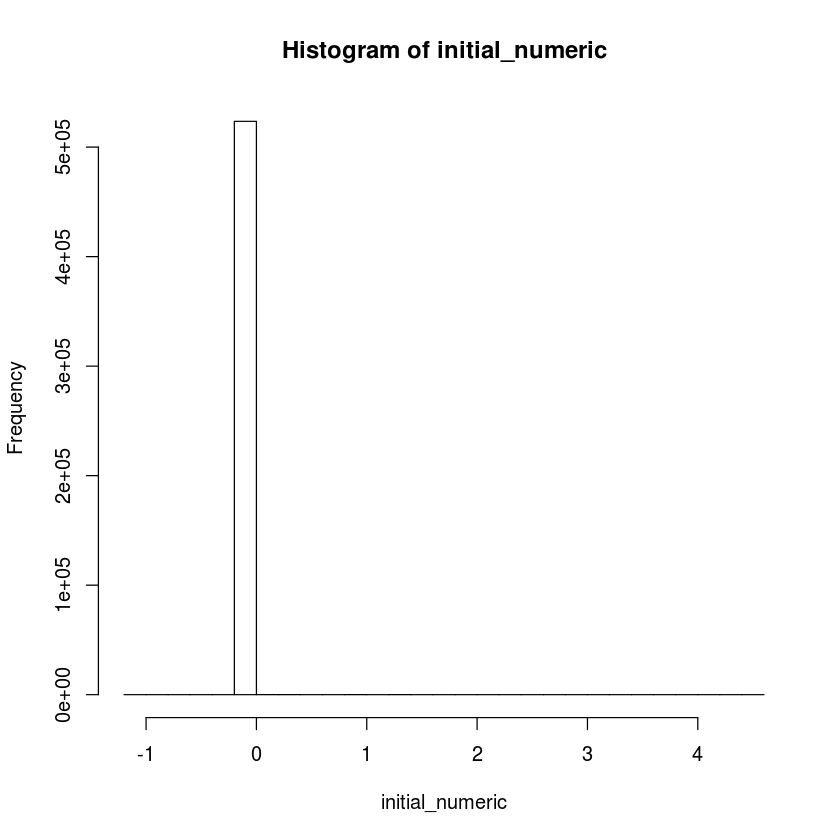

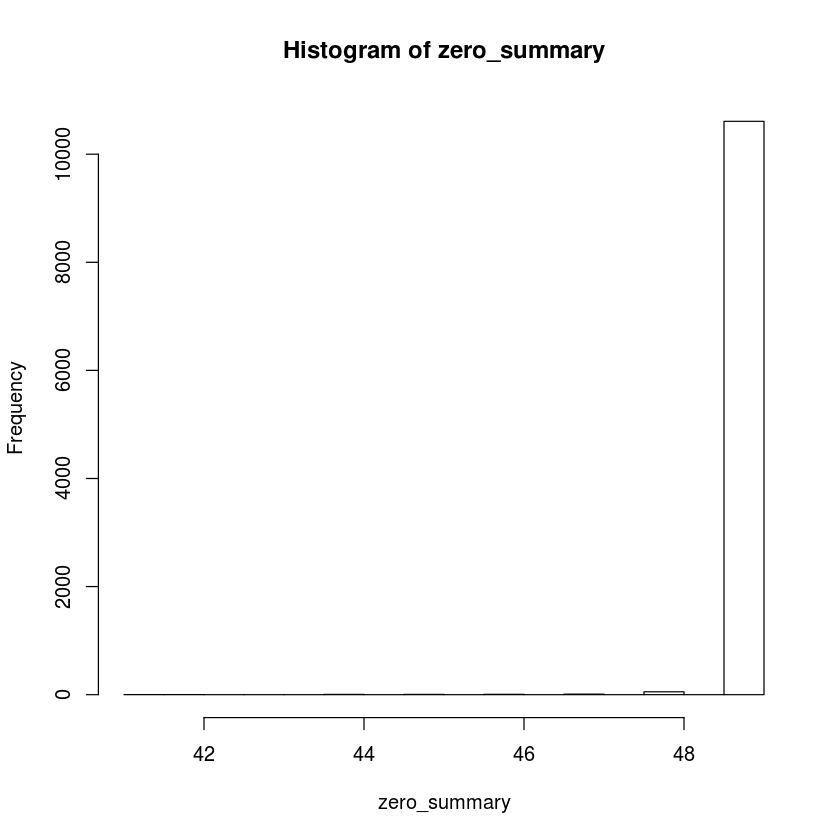

In [10]:
plot_est(single_initial_est)

In [ ]:
# alpha = 0

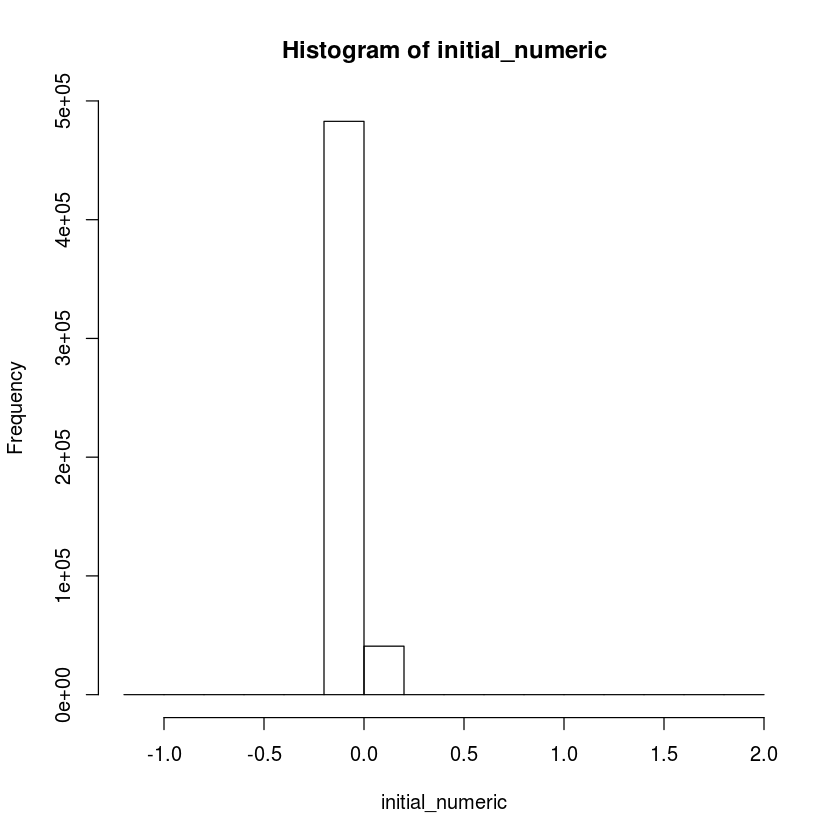

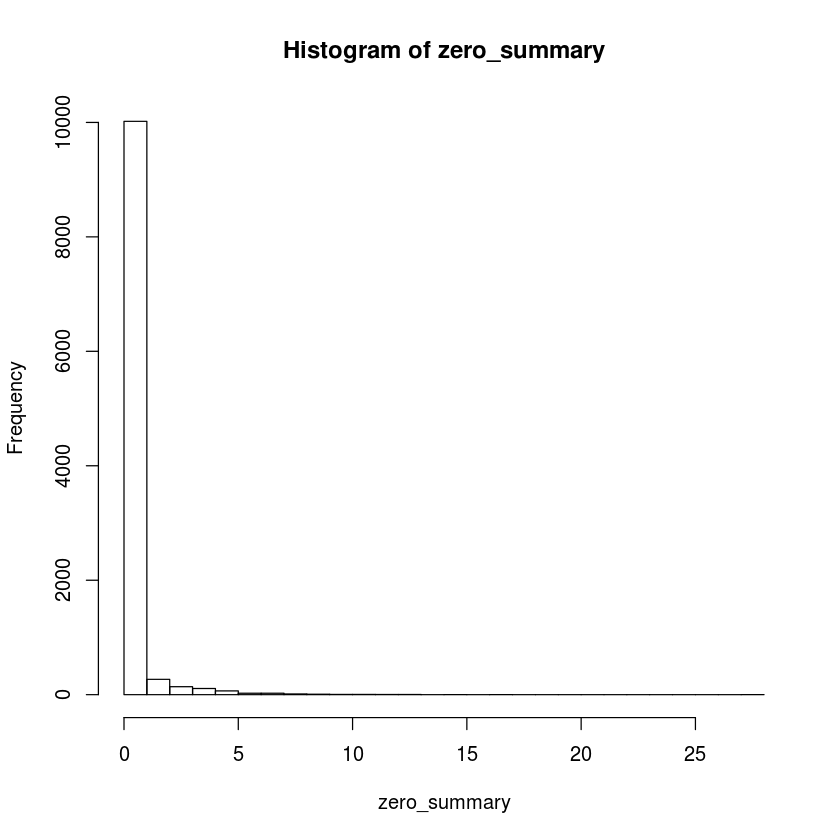

In [15]:
plot_est(single_initial_est)

In [16]:
sum(single_initial_est != 0)

[1] 520504

In [17]:
X_all = list()
Y_all = list()
glmnet_list = list()
for(t in 1:T_num){
    X_all_tmp = sub_id_map[[t]]
    X_all[[t]] = apply(as.matrix(dose_std[,X_all_tmp]),1,as.numeric)
    Y_all[[t]] = Y[[t]][which(sub_id_map_exp[[t]] == T), 2]
}
# initial values 
single_initial_est = matrix(0, ncol(X_all[[1]]), T_num)
for(t in 1:T_num){
    IRdisplay::display_html(paste0("Tissue ", t))
    tt = cv.glmnet(X_all[[t]], Y_all[[t]], alpha = 1, nlambda = 10, nfolds = 5)
    glmnet_list[[t]] = tt
    single_initial_est[,t] = tt$glmnet.fit$beta[,which.min(tt$cvm)]
}



Tissue 1

Tissue 2

Tissue 3

Tissue 4

Tissue 5

Tissue 6

Tissue 7

Tissue 8

Tissue 9

Tissue 10

Tissue 11

Tissue 12

Tissue 13

Tissue 14

Tissue 15

Tissue 16

Tissue 17

Tissue 18

Tissue 19

Tissue 20

Tissue 21

Tissue 22

Tissue 23

Tissue 24

Tissue 25

Tissue 26

Tissue 27

Tissue 28

Tissue 29

Tissue 30

Tissue 31

Tissue 32

Tissue 33

Tissue 34

Tissue 35

Tissue 36

Tissue 37

Tissue 38

Tissue 39

Tissue 40

Tissue 41

Tissue 42

Tissue 43

Tissue 44

Tissue 45

Tissue 46

Tissue 47

Tissue 48

Tissue 49

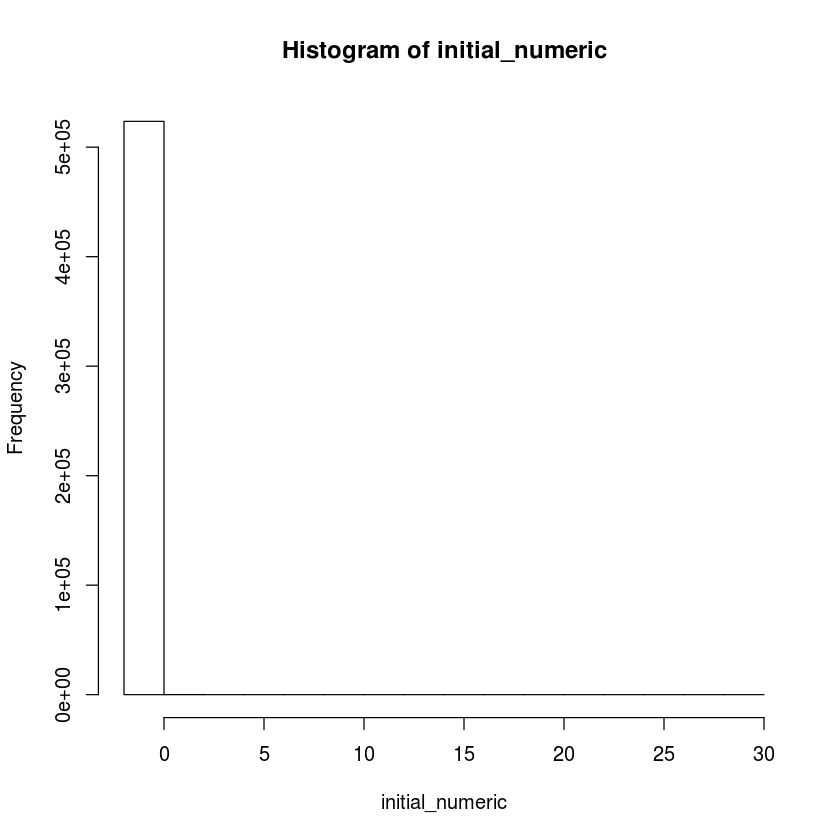

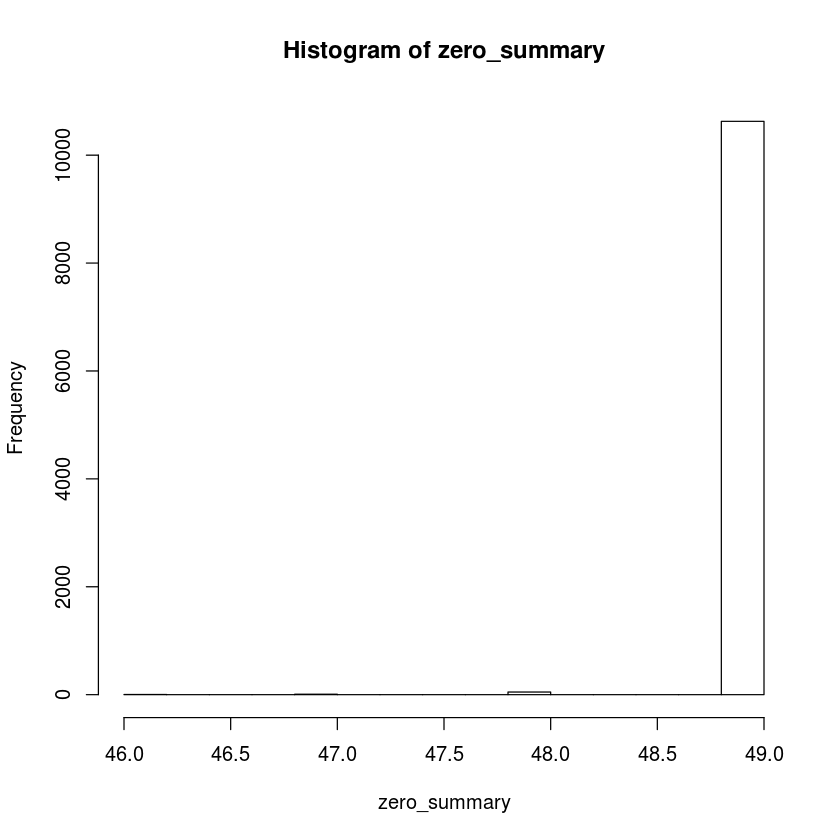

In [18]:
plot_est(single_initial_est)

In [19]:
sum(single_initial_est != 0)

[1] 74

In [8]:
#-------------------------- main ---------------------------#  

# testing
if (T) {
    args <- c("21", "3")
} 
#args = commandArgs(trailingOnly = TRUE)
chr = as.numeric(args[1])
    

#-------------------------- data import ---------------------------#  


chr = "21"
k = "1"
genotype_dir <- "/ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/"
gtex_dir <- "/gpfs/loomis/project/zhao/zy92/GTEX/" 
glist = dir(paste0(gtex_dir, "adjusted_expr/chr", chr))


# idx 

chr_str <- paste0("chr", chr, "/")
gene_vec <- list.files(paste0(genotype_dir, chr_str))

gene_idx = which(glist == "ENSG00000184012")
dose_idx = which(startsWith(gene_vec, "ENSG00000184012"))

gene_id <- gene_vec[dose_idx]
g <- glist[gene_idx]
dose_path = paste0(genotype_dir, chr_str, gene_id, "/", gene_id)
Yt = dir(paste0(gtex_dir, "adjusted_expr/", chr_str, g, "/"))
P = length(Yt)
output_dir = "/gpfs/loomis/project/zhao/zy92/GTEX/output/" 
ntune = 5
if_verbose = T
# loading fast matrix operations 
#sourceCpp("/gpfs/project/zhao/zy92/utmost_update/CTIMP/MatrixMtp.cpp") # call the C++ file and we have three functions as armaMatMult，eigenMatMult，eigenMapMatMult.
sourceCpp("/gpfs/loomis/project/zhao/zy92/utmost_update/CTIMP/MatrixMtp.cpp") # call the C++ file and we have three functions as armaMatMult，eigenMatMult，eigenMapMatMult.






# create dirs
dir.create(paste0(output_dir, "chr", chr), showWarnings = FALSE)
dir.create(paste0(output_dir, "chr", chr, "/", gene_id), showWarnings = FALSE)
setwd(paste0(output_dir, "chr", chr, "/", gene_id))

# expr files 
cat("INFO: loading expression files...")
Y = list()
T_idx = c()
for(t in 1:P){
    tmp_exp = read.table(paste0(gtex_dir, "adjusted_expr/chr", chr, "/", g, "/", Yt[t]), header=F)
    # check if the y is constant
    if (!all(tmp_exp[,2] == tmp_exp[1,2])) {
        T_idx = c(T_idx, t)
        Y[[length(T_idx)]] = tmp_exp 
    }
     
}
Yt = Yt[T_idx]
ssize = unlist(lapply(Y, nrow))
T_num = length(Yt)
P = T_num

# genotype files 
cat("INFO: loading genotype files...")	
genotype_info <- read_plink(dose_path)
dose = genotype_info$X #[1:1000, ]
dose_std = dose

# center the dose
for(j in 1:nrow(dose)){
    dose_std[j, is.na(dose[j, ])] <- mean(dose[j, ], na.rm = T)
    dose_std[j, ] <- dose_std[j, ] - mean(dose[j, ], na.rm = T)
}

# covariance matrix 
n_sample = ncol(dose_std)
tmp = t(as.matrix(dose_std))
XX = eigenMatMult(t(tmp), tmp)/n_sample 
Xnorm = diag(XX)
remove(tmp)
remove(XX)
sub_id = colnames(dose_std)

# number of snps
M = nrow(dose_std)
sub_id_map = list()
sub_id_map_exp = list()

# sample matching 
for(t in 1:T_num){
    #tmp = rep(0, nrow(Y[[t]]))
    exp_id <- as.character(sapply(Y[[t]][,1], function(x) substr(x, 1, 10)))
    # index of ids that have matched genotypes 
    # exp_id based on order of exp_id
    match_id <- match(exp_id, sub_id)
    sub_id_map[[t]] <- na.omit(match_id)
    sub_id_map_exp[[t]] <- !is.na(match_id)  
}



INFO: loading expression files...INFO: loading genotype files...

Reading: /ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/chr21/ENSG00000184012.11/ENSG00000184012.11.bim

Reading: /ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/chr21/ENSG00000184012.11/ENSG00000184012.11.fam

Reading: /ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/chr21/ENSG00000184012.11/ENSG00000184012.11.bed



In [ ]:
plot_est <- function(initial_numeric) {
    initial_numeric_df = data.frame(matrix(initial_numeric, nrow= 49))
    zero_summary = apply(initial_numeric_df, 2, function(x) sum(x == 0))
    hist(initial_numeric)
    hist(zero_summary, breaks = 20)
}

In [ ]:
plot_est(single_initial_est)

In [ ]:
#-------------------------- main ---------------------------#  

# testing
if (T) {
    args <- c("21", "3")
} 
#args = commandArgs(trailingOnly = TRUE)
chr = as.numeric(args[1])
    

#-------------------------- data import ---------------------------#  


chr = "21"
k = "1"
genotype_dir <- "/ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/"
gtex_dir <- "/gpfs/loomis/project/zhao/zy92/GTEX/" 
glist = dir(paste0(gtex_dir, "adjusted_expr/chr", chr))


# idx 

chr_str <- paste0("chr", chr, "/")
gene_vec <- list.files(paste0(genotype_dir, chr_str))

gene_idx = which(glist == "ENSG00000184012")
dose_idx = which(startsWith(gene_vec, "ENSG00000184012"))

gene_id <- gene_vec[dose_idx]
g <- glist[gene_idx]
dose_path = paste0(genotype_dir, chr_str, gene_id, "/", gene_id)
Yt = dir(paste0(gtex_dir, "adjusted_expr/", chr_str, g, "/"))
P = length(Yt)
output_dir = "/gpfs/loomis/project/zhao/zy92/GTEX/output/" 
ntune = 5
if_verbose = T
# loading fast matrix operations 
#sourceCpp("/gpfs/project/zhao/zy92/utmost_update/CTIMP/MatrixMtp.cpp") # call the C++ file and we have three functions as armaMatMult，eigenMatMult，eigenMapMatMult.
sourceCpp("/gpfs/loomis/project/zhao/zy92/utmost_update/CTIMP/MatrixMtp.cpp") # call the C++ file and we have three functions as armaMatMult，eigenMatMult，eigenMapMatMult.






# create dirs
dir.create(paste0(output_dir, "chr", chr), showWarnings = FALSE)
dir.create(paste0(output_dir, "chr", chr, "/", gene_id), showWarnings = FALSE)
setwd(paste0(output_dir, "chr", chr, "/", gene_id))

# expr files 
cat("INFO: loading expression files...")
Y = list()
T_idx = c()
for(t in 1:P){
    tmp_exp = read.table(paste0(gtex_dir, "adjusted_expr/chr", chr, "/", g, "/", Yt[t]), header=F)
    # check if the y is constant
    if (!all(tmp_exp[,2] == tmp_exp[1,2])) {
        T_idx = c(T_idx, t)
        Y[[length(T_idx)]] = tmp_exp 
    }
     
}
Yt = Yt[T_idx]
ssize = unlist(lapply(Y, nrow))
T_num = length(Yt)
P = T_num

# genotype files 
cat("INFO: loading genotype files...")	
genotype_info <- read_plink(dose_path)
dose = genotype_info$X #[1:1000, ]
dose_std = dose

# center the dose
for(j in 1:nrow(dose)){
    dose_std[j, is.na(dose[j, ])] <- mean(dose[j, ], na.rm = T)
    dose_std[j, ] <- dose_std[j, ] - mean(dose[j, ], na.rm = T)
}

# covariance matrix 
n_sample = ncol(dose_std)
tmp = t(as.matrix(dose_std))
XX = eigenMatMult(t(tmp), tmp)/n_sample 
Xnorm = diag(XX)
remove(tmp)
remove(XX)
sub_id = colnames(dose_std)

# number of snps
M = nrow(dose_std)
sub_id_map = list()
sub_id_map_exp = list()

# sample matching 
for(t in 1:T_num){
    #tmp = rep(0, nrow(Y[[t]]))
    exp_id <- as.character(sapply(Y[[t]][,1], function(x) substr(x, 1, 10)))
    # index of ids that have matched genotypes 
    # exp_id based on order of exp_id
    match_id <- match(exp_id, sub_id)
    sub_id_map[[t]] <- na.omit(match_id)
    sub_id_map_exp[[t]] <- !is.na(match_id)  
}

# cv                  

In [3]:
X_all = list()
Y_all = list()
for(t in 1:T_num){
    X_all_tmp = sub_id_map[[t]]
    X_all[[t]] = apply(as.matrix(dose_std[,X_all_tmp]),1,as.numeric)
    Y_all[[t]] = Y[[t]][which(sub_id_map_exp[[t]] == T), 2]
}
# initial values 
single_initial_est = matrix(0, ncol(X_all[[1]]), T_num)
for(t in 1:T_num){
    IRdisplay::display_html(paste0("Tissue ", t))
    tt = cv.glmnet(X_all[[t]], Y_all[[t]], alpha = 0.5, nfolds = 5)
    single_initial_est[,t] = tt$glmnet.fit$beta[,which.min(tt$cvm)]
}



Tissue 1

Tissue 2

Tissue 3

Tissue 4

Tissue 5

Tissue 6

Tissue 7

Tissue 8

Tissue 9

Tissue 10

Tissue 11

Tissue 12

Tissue 13

Tissue 14

Tissue 15

Tissue 16

Tissue 17

Tissue 18

Tissue 19

Tissue 20

Tissue 21

Tissue 22

Tissue 23

Tissue 24

Tissue 25

Tissue 26

Tissue 27

Tissue 28

Tissue 29

Tissue 30

Tissue 31

Tissue 32

Tissue 33

Tissue 34

Tissue 35

Tissue 36

Tissue 37

Tissue 38

Tissue 39

Tissue 40

Tissue 41

Tissue 42

Tissue 43

Tissue 44

Tissue 45

Tissue 46

Tissue 47

Tissue 48

Tissue 49

In [4]:
plot_est <- function(initial_numeric) {
    initial_numeric_df = data.frame(matrix(initial_numeric, nrow= 49))
    zero_summary = apply(initial_numeric_df, 2, function(x) sum(x == 0))
    hist(initial_numeric)
    hist(zero_summary, breaks = 20)
}

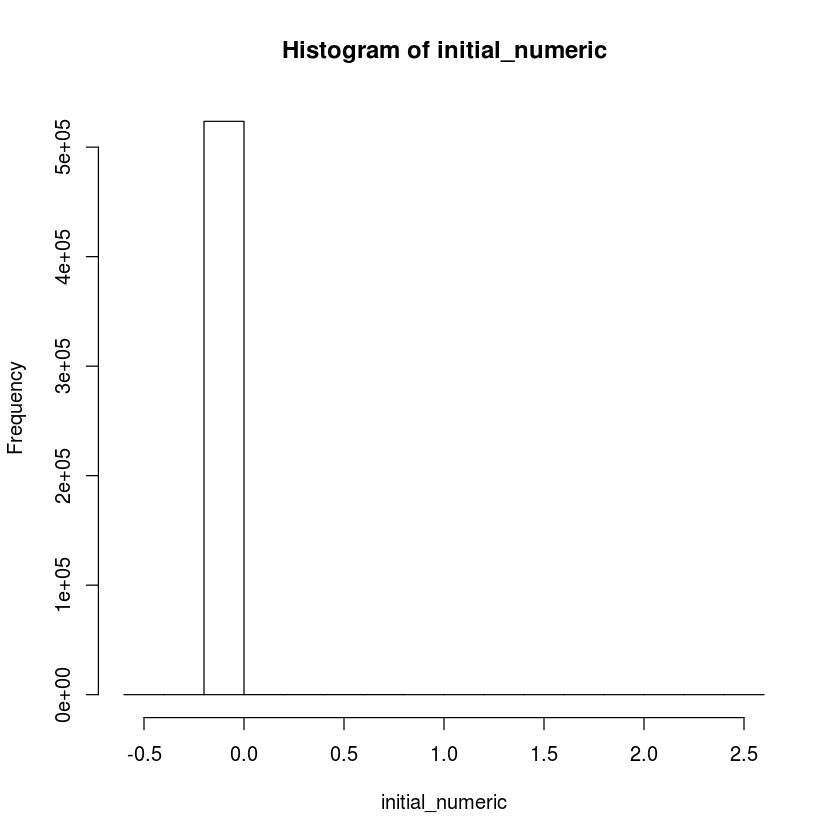

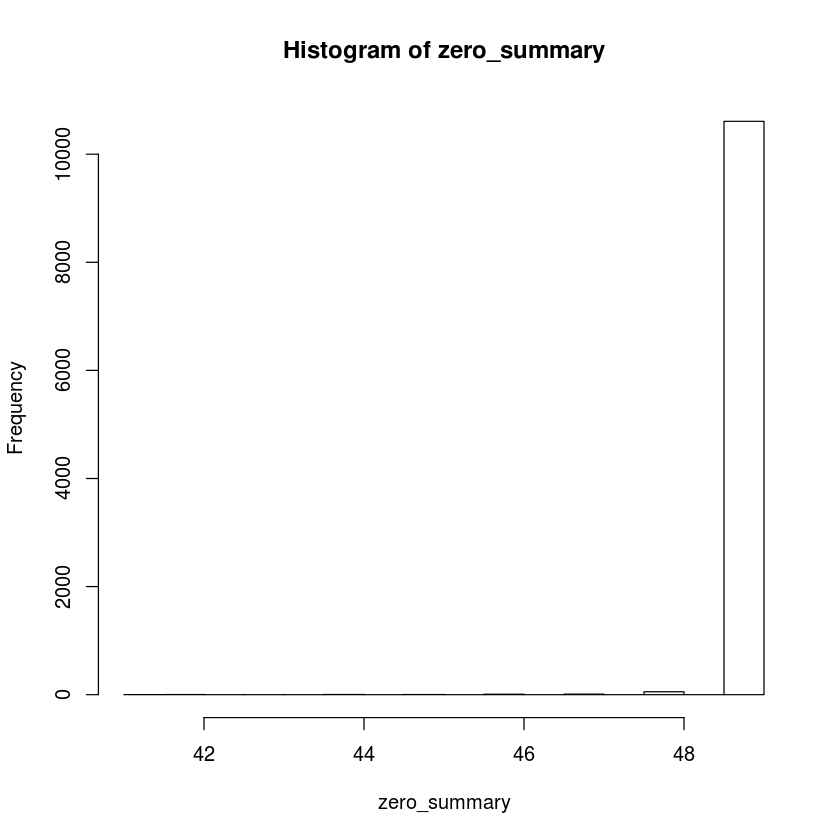

In [5]:
plot_est(single_initial_est)

In [ ]:
#-------------------------- main ---------------------------#  

# testing
if (T) {
    args <- c("21", "3")
} 
#args = commandArgs(trailingOnly = TRUE)
chr = as.numeric(args[1])
    

#-------------------------- data import ---------------------------#  


chr = "21"
k = "1"
genotype_dir <- "/ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/"
gtex_dir <- "/gpfs/loomis/project/zhao/zy92/GTEX/" 
glist = dir(paste0(gtex_dir, "adjusted_expr/chr", chr))


# idx 

chr_str <- paste0("chr", chr, "/")
gene_vec <- list.files(paste0(genotype_dir, chr_str))

gene_idx = which(glist == "ENSG00000184012")
dose_idx = which(startsWith(gene_vec, "ENSG00000184012"))

gene_id <- gene_vec[dose_idx]
g <- glist[gene_idx]
dose_path = paste0(genotype_dir, chr_str, gene_id, "/", gene_id)
Yt = dir(paste0(gtex_dir, "adjusted_expr/", chr_str, g, "/"))
P = length(Yt)
output_dir = "/gpfs/loomis/project/zhao/zy92/GTEX/output/" 
ntune = 5
if_verbose = T
# loading fast matrix operations 
#sourceCpp("/gpfs/project/zhao/zy92/utmost_update/CTIMP/MatrixMtp.cpp") # call the C++ file and we have three functions as armaMatMult，eigenMatMult，eigenMapMatMult.
sourceCpp("/gpfs/loomis/project/zhao/zy92/utmost_update/CTIMP/MatrixMtp.cpp") # call the C++ file and we have three functions as armaMatMult，eigenMatMult，eigenMapMatMult.






# create dirs
dir.create(paste0(output_dir, "chr", chr), showWarnings = FALSE)
dir.create(paste0(output_dir, "chr", chr, "/", gene_id), showWarnings = FALSE)
setwd(paste0(output_dir, "chr", chr, "/", gene_id))

# expr files 
cat("INFO: loading expression files...")
Y = list()
T_idx = c()
for(t in 1:P){
    tmp_exp = read.table(paste0(gtex_dir, "adjusted_expr/chr", chr, "/", g, "/", Yt[t]), header=F)
    # check if the y is constant
    if (!all(tmp_exp[,2] == tmp_exp[1,2])) {
        T_idx = c(T_idx, t)
        Y[[length(T_idx)]] = tmp_exp 
    }
     
}
Yt = Yt[T_idx]
ssize = unlist(lapply(Y, nrow))
T_num = length(Yt)
P = T_num

# genotype files 
cat("INFO: loading genotype files...")	
genotype_info <- read_plink(dose_path)
dose = genotype_info$X #[1:1000, ]
dose_std = dose

# center the dose
for(j in 1:nrow(dose)){
    dose_std[j, is.na(dose[j, ])] <- mean(dose[j, ], na.rm = T)
    dose_std[j, ] <- dose_std[j, ] - mean(dose[j, ], na.rm = T)
}

# covariance matrix 
n_sample = ncol(dose_std)
tmp = t(as.matrix(dose_std))
XX = eigenMatMult(t(tmp), tmp)/n_sample 
Xnorm = diag(XX)
remove(tmp)
remove(XX)
sub_id = colnames(dose_std)

# number of snps
M = nrow(dose_std)
sub_id_map = list()
sub_id_map_exp = list()

# sample matching 
for(t in 1:T_num){
    #tmp = rep(0, nrow(Y[[t]]))
    exp_id <- as.character(sapply(Y[[t]][,1], function(x) substr(x, 1, 10)))
    # index of ids that have matched genotypes 
    # exp_id based on order of exp_id
    match_id <- match(exp_id, sub_id)
    sub_id_map[[t]] <- na.omit(match_id)
    sub_id_map_exp[[t]] <- !is.na(match_id)  
}

# cv                  

In [3]:
X_all = list()
Y_all = list()
for(t in 1:T_num){
    X_all_tmp = sub_id_map[[t]]
    X_all[[t]] = apply(as.matrix(dose_std[,X_all_tmp]),1,as.numeric)
    Y_all[[t]] = Y[[t]][which(sub_id_map_exp[[t]] == T), 2]
}
# initial values 
single_initial_est = matrix(0, ncol(X_all[[1]]), T_num)
for(t in 1:T_num){
    IRdisplay::display_html(paste0("Tissue ", t))
    tt = cv.glmnet(X_all[[t]], Y_all[[t]], alpha = 0.5, nfolds = 5)
    single_initial_est[,t] = tt$glmnet.fit$beta[,which.min(tt$cvm)]
}



Tissue 1

Tissue 2

Tissue 3

Tissue 4

Tissue 5

Tissue 6

Tissue 7

Tissue 8

Tissue 9

Tissue 10

Tissue 11

Tissue 12

Tissue 13

Tissue 14

Tissue 15

Tissue 16

Tissue 17

Tissue 18

Tissue 19

Tissue 20

Tissue 21

Tissue 22

Tissue 23

Tissue 24

Tissue 25

Tissue 26

Tissue 27

Tissue 28

Tissue 29

Tissue 30

Tissue 31

Tissue 32

Tissue 33

Tissue 34

Tissue 35

Tissue 36

Tissue 37

Tissue 38

Tissue 39

Tissue 40

Tissue 41

Tissue 42

Tissue 43

Tissue 44

Tissue 45

Tissue 46

Tissue 47

Tissue 48

Tissue 49

In [4]:
plot_est <- function(initial_numeric) {
    initial_numeric_df = data.frame(matrix(initial_numeric, nrow= 49))
    zero_summary = apply(initial_numeric_df, 2, function(x) sum(x == 0))
    hist(initial_numeric)
    hist(zero_summary, breaks = 20)
}

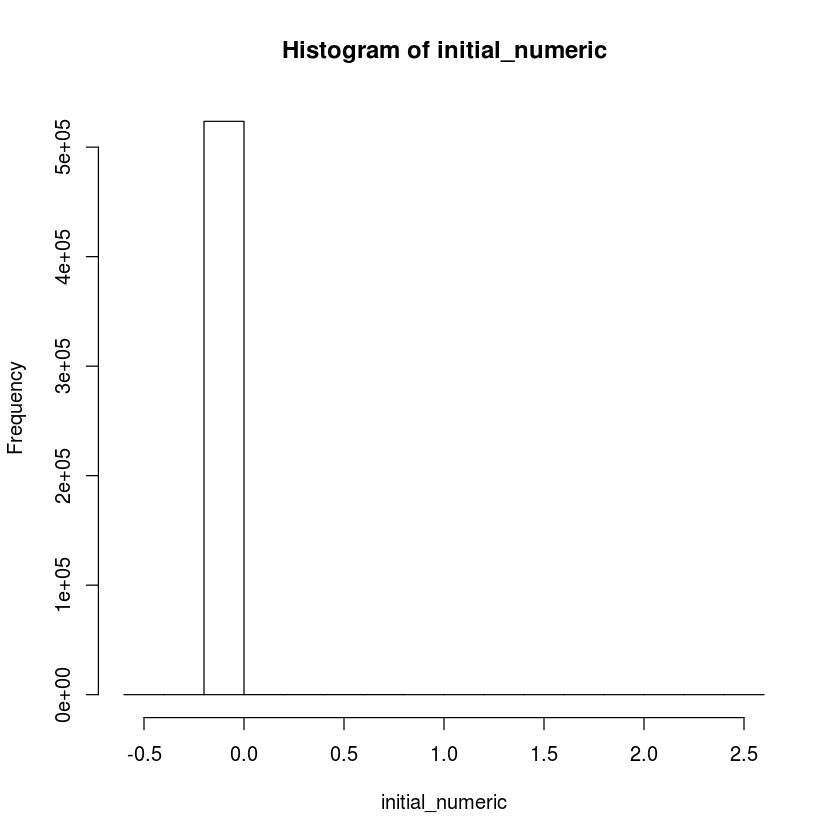

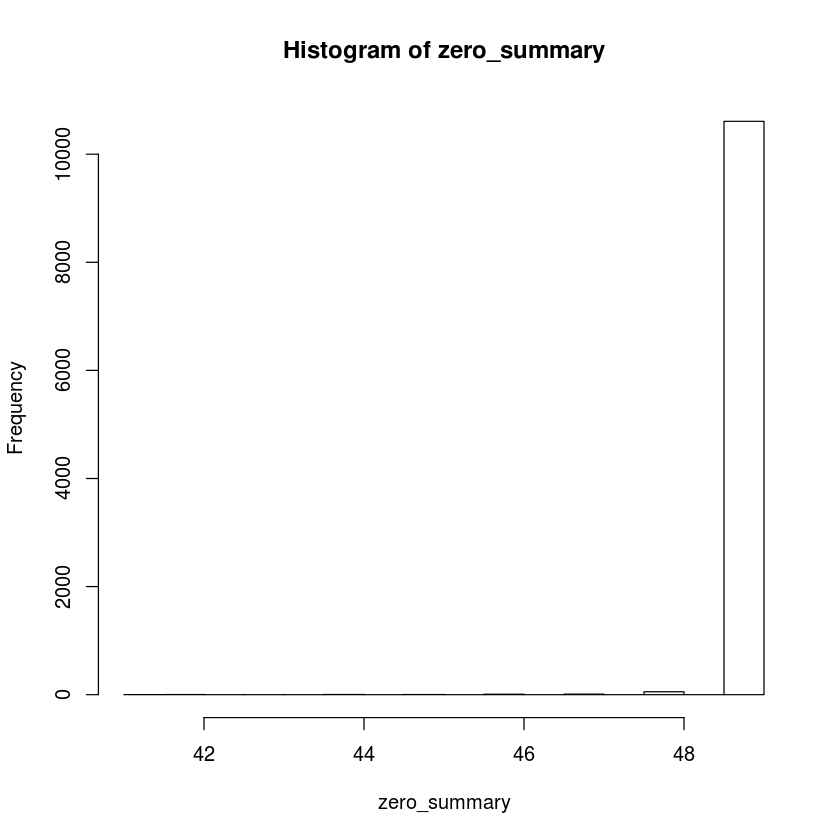

In [5]:
plot_est(single_initial_est)

In [ ]:

#-------------------------- main ---------------------------#  

# testing
if (F) {
    args <- c("21", "3")
} 
#args = commandArgs(trailingOnly = TRUE)
chr = as.numeric(args[1])
    

#-------------------------- data import ---------------------------#  


chr = "21"
k = "1"
genotype_dir <- "/ysm-gpfs/project/wl382/GTEx_v8/genotype/cis_loc/"
gtex_dir <- "/gpfs/loomis/project/zhao/zy92/GTEX/" 
glist = dir(paste0(gtex_dir, "adjusted_expr/chr", chr))


# idx 

chr_str <- paste0("chr", chr, "/")
gene_vec <- list.files(paste0(genotype_dir, chr_str))

gene_idx = which(glist == "ENSG00000184012")
dose_idx = which(startsWith(gene_vec, "ENSG00000184012"))

gene_id <- gene_vec[dose_idx]
g <- glist[gene_idx]
dose_path = paste0(genotype_dir, chr_str, gene_id, "/", gene_id)
Yt = dir(paste0(gtex_dir, "adjusted_expr/", chr_str, g, "/"))
P = length(Yt)
output_dir = "/gpfs/loomis/project/zhao/zy92/GTEX/output/" 
ntune = 5
if_verbose = T
# loading fast matrix operations 
#sourceCpp("/gpfs/project/zhao/zy92/utmost_update/CTIMP/MatrixMtp.cpp") # call the C++ file and we have three functions as armaMatMult，eigenMatMult，eigenMapMatMult.
sourceCpp("/gpfs/loomis/project/zhao/zy92/utmost_update/CTIMP/MatrixMtp.cpp") # call the C++ file and we have three functions as armaMatMult，eigenMatMult，eigenMapMatMult.






# create dirs
dir.create(paste0(output_dir, "chr", chr), showWarnings = FALSE)
dir.create(paste0(output_dir, "chr", chr, "/", gene_id), showWarnings = FALSE)
setwd(paste0(output_dir, "chr", chr, "/", gene_id))

# expr files 
cat("INFO: loading expression files...")
Y = list()
T_idx = c()
for(t in 1:P){
    tmp_exp = read.table(paste0(gtex_dir, "adjusted_expr/chr", chr, "/", g, "/", Yt[t]), header=F)
    # check if the y is constant
    if (!all(tmp_exp[,2] == tmp_exp[1,2])) {
        T_idx = c(T_idx, t)
        Y[[length(T_idx)]] = tmp_exp 
    }
     
}
Yt = Yt[T_idx]
ssize = unlist(lapply(Y, nrow))
T_num = length(Yt)
P = T_num

# genotype files 
cat("INFO: loading genotype files...")	
genotype_info <- read_plink(dose_path)
dose = genotype_info$X #[1:1000, ]
dose_std = dose

# center the dose
for(j in 1:nrow(dose)){
    dose_std[j, is.na(dose[j, ])] <- mean(dose[j, ], na.rm = T)
    dose_std[j, ] <- dose_std[j, ] - mean(dose[j, ], na.rm = T)
}

# covariance matrix 
n_sample = ncol(dose_std)
tmp = t(as.matrix(dose_std))
XX = eigenMatMult(t(tmp), tmp)/n_sample 
Xnorm = diag(XX)
remove(tmp)
remove(XX)
sub_id = colnames(dose_std)

# number of snps
M = nrow(dose_std)
sub_id_map = list()
sub_id_map_exp = list()

# sample matching 
for(t in 1:T_num){
    #tmp = rep(0, nrow(Y[[t]]))
    exp_id <- as.character(sapply(Y[[t]][,1], function(x) substr(x, 1, 10)))
    # index of ids that have matched genotypes 
    # exp_id based on order of exp_id
    match_id <- match(exp_id, sub_id)
    sub_id_map[[t]] <- na.omit(match_id)
    sub_id_map_exp[[t]] <- !is.na(match_id)  
}

# cv                                   
fold = 5
#IR                                
IRdisplay::display_html("INFO: CV preparation")
cv_config = cv_helper(n_sample, fold)
cv_perm = cv_config$perm
cv_idx = cv_config$idx

single_res_test = list()
single_lam = matrix(0, fold, T_num)
single_theta_est = list()
	
multi_res_test = list()
multi_lam = matrix(0, fold, 2)
multi_theta_est = list()

multi_res_test2 = list()
multi_lam2 = array(0, dim=c(fold, T_num, 2))
multi_theta_est2 = list()
                                  

res_tune = list()
rec_lamv = matrix(0, fold, ntune)                                 
                                  
for(f in 1:fold){
#for(f in 1:1){
    bgt = Sys.time()
    IRdisplay::display_html(paste0("INFO: fold ", f))
    test_index = cv_perm[cv_idx[f,1]:cv_idx[f,2]]
    test_id = sub_id[test_index]

    # move the tuning idx to another idx block
    tuning_index = cv_perm[cv_idx[f%%fold+1,1]:cv_idx[f%%fold+1,2]]
    tuning_id = sub_id[tuning_index]

    # idx list
    X_test = list()
    Y_test = list()
    X_tune = list()
    Y_tune = list()
    X_train = list()
    Y_train = list()
    for(t in 1:T_num){
        # idx matching  
        id_filter = !(sub_id_map[[t]]%in%c(test_index,tuning_index))
        X_train_tmp = sub_id_map[[t]][id_filter]
        Y_train_tmp = which(sub_id_map_exp[[t]] == T)[id_filter]
        tuning_id_filter = sub_id_map[[t]]%in%tuning_index
        X_tuning_tmp = sub_id_map[[t]][tuning_id_filter]
        Y_tuning_tmp = which(sub_id_map_exp[[t]] == T)[tuning_id_filter]
        testing_id_filter = sub_id_map[[t]]%in%test_index
        X_test_tmp = sub_id_map[[t]][testing_id_filter]
        Y_test_tmp = which(sub_id_map_exp[[t]] == T)[testing_id_filter]
        # training data
        X_train[[t]] = apply(as.matrix(dose_std[,X_train_tmp]),1,as.numeric)
        Y_train[[t]] = Y[[t]][Y_train_tmp, 2]
        X_tune[[t]] = apply(as.matrix(dose_std[,X_tuning_tmp]),1,as.numeric)
        Y_tune[[t]] = Y[[t]][Y_tuning_tmp, 2]
        X_test[[t]] = apply(as.matrix(dose_std[,X_test_tmp]),1,as.numeric)
        Y_test[[t]] = Y[[t]][Y_test_tmp, 2]
        #IRdisplay::display_html(length(X_train_tmp))
        #IRdisplay::display_html(length(Y_train_tmp))
        #IRdisplay::display_html(dim(X_train[[t]]))
        #IRdisplay::display_html(length(Y_train[[t]]))
    }

    ## model training ##	
    ## train elastic net and used average lambda as tuning parameters ##
    single_initial_est = matrix(0, ncol(X_train[[1]]), T_num)
    single_summary = list()
    for(t in 1:T_num) {
        #print(Y_train[[t]])
        #print(sum(is.na(X_train[[t]])))
        if (t %% 5 == 0) {
            IRdisplay::display_html(paste0("INFO: glmnet cv tissue", t))
        }
        
        
        tt = cv.glmnet(X_train[[t]], Y_train[[t]], alpha = 0.5, nfolds = 5)
        single_summary[[t]] = tt
        single_initial_est[,t] = tt$glmnet.fit$beta[,which.min(tt$cvm)]
    }
    ## performance of Elastic net on tuning and testing data with various tuning parameters
    els_output = elastic_net_mse(single_summary, X_tune, Y_tune, X_test, Y_test)
    single_res_test[[f]] = els_output$mse
    single_lam[f,] = els_output$lam
    single_theta_est[[f]] = els_output$est
    remove(els_output)

    
    ## use elastic net ests row norm as weights ##
    lam_range = minmax_lambda(single_summary)
    sig_norm = apply(single_initial_est, 1, function(x){sqrt(sum(x^2))})
    sig_norm[sig_norm==0] = rep(min(sig_norm[sig_norm>0]), sum(sig_norm==0))/2
    sig_norm = sig_norm/sum(sig_norm)
    weights2 = 1/sig_norm; weights2 = weights2/sum(weights2);

    tis_norm = apply(single_initial_est, 2, function(x){sum(abs(x))})
    tis_norm[tis_norm==0] = rep(min(tis_norm[tis_norm>0]), sum(tis_norm==0))/2
    tis_norm = tis_norm/sum(tis_norm)
    weights1 = 1/tis_norm; weights1 = weights1/sum(weights1);
    lam_V = seq(lam_range[1], lam_range[2], length.out = ntune)
    
    # initial value
    initial_numeric = as.numeric(single_initial_est)
	remove(single_summary)
    remove(single_initial_est)


    #-------------------------- train - validate - test ---------------------------#
    IRdisplay::display_html('starting train-validate-test\n')
    ## preparation
    XY = grad_prep(X_train, Y_train)
    #bgt = Sys.time()
    XX_train = lapply(X_train, function(x) { eigenMatMult(t(x), x)/nrow(x)})
    #edt = Sys.time()
    #print(edt-bgt)
    
    spsz = unlist(lapply(X_train,nrow))
    #res_tune = rep(0, ntune)
    res_tune[[f]] = array(-1, dim=c(ntune, ntune, T_num))
    #best.lam = 0
    rec_lamv[f,] = lam_V
    for(lam1 in 1:ntune){
        for(lam2 in 1:ntune){
            single_est = matrix(initial_numeric, M, T_num )
            ans = glasso(X=X_train, Y=Y_train, X1=X_tune, Y1=Y_tune, XX=XX_train, XY=XY, Xnorm=Xnorm, lambda1=lam_V[lam1]/spsz, lambda2=lam_V[lam2], theta=single_est, verbose = if_verbose)
            if(sum(ans$est!=0)>0){
                res_tune[[f]][lam1,lam2, ] = ans$tune_err
                if (if_verbose) { cat("lambda1=",lam_V[lam1], "; lambda2=", lam_V[lam2], "; avg tune err=", ans$avg_tune_err, '\n') }
                remove(single_est); remove(ans);
            }else{
                remove(single_est); remove(ans);
                break
            }			
        }
    }
    
    
    #-------------------------- save results on test set for evaluation ---------------------------#
    IRdisplay::display_html("saving cross-validation results for evaluation and analysis\n")
    avg_tune_res = apply(res_tune[[f]], c(1,2), mean)
    best.lam = which(avg_tune_res == min(avg_tune_res[avg_tune_res>=0]), arr.ind = TRUE)[1,]
    single_est = matrix(initial_numeric, M, P)
    ans = glasso(X=X_train, Y=Y_train, X1=X_tune, Y1=Y_tune, XX=XX_train, XY=XY, Xnorm=Xnorm, lambda1=lam_V[best.lam[1]]/spsz, lambda2=lam_V[best.lam[2]], theta=single_est, verbose = if_verbose)
    multi_res_test[[f]] = multi_mse(ans$est, X_test, Y_test)
    multi_lam[f,] = lam_V[best.lam]
    multi_theta_est[[f]] = ans$est
    remove(single_est)
    remove(ans)

    
    edt = Sys.time()
    print(edt-bgt)
} # end of cv loop
edt_origin = Sys.time() 
print("Final Time Cost: ")                                 
print(edt_origin-bgt_origin)
   

In [4]:
dim(initial_numeric)

NULL

In [ ]:
head(initial_numeric)
length(initial_numeric)

In [6]:
plot_est <- function(initial_numeric) {
    initial_numeric_df = data.frame(matrix(initial_numeric, nrow= 49))
    zero_summary = apply(initial_numeric_df, 2, function(x) sum(x == 0))
    hist(initial_numeric)
    hist(zero_summary, breaks = 20)
}

In [17]:
initial_numeric_df = data.frame(matrix(initial_numeric, 49, 1000))

In [18]:
zero_summary = apply(initial_numeric_df, 2, function(x) sum(x == 0))

[1] 0

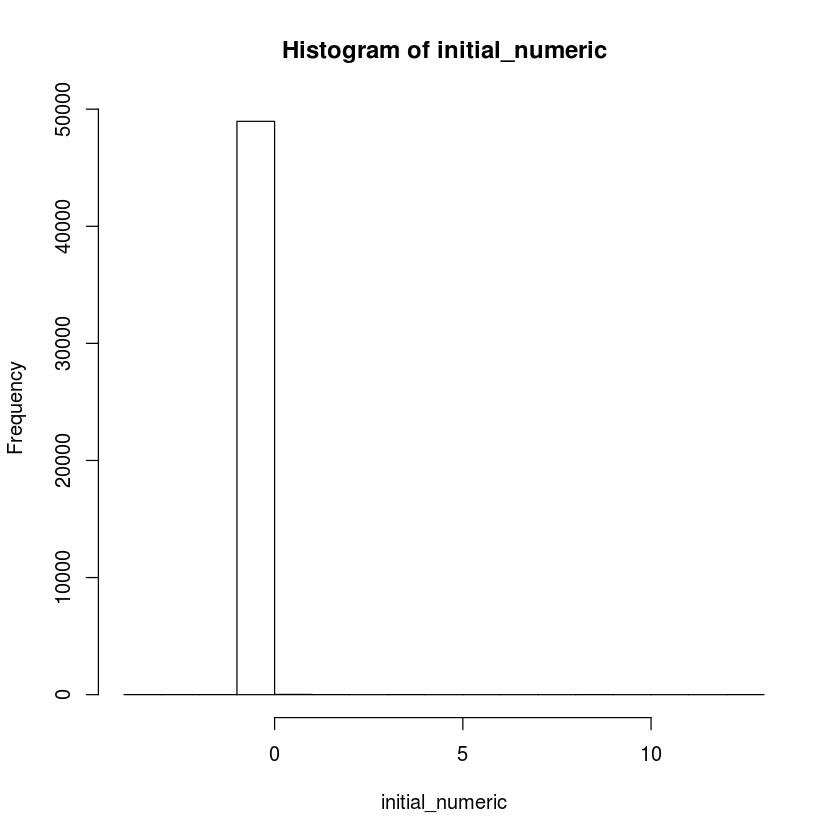

In [15]:
sum(is.na(initial_numeric_df))
hist(initial_numeric)

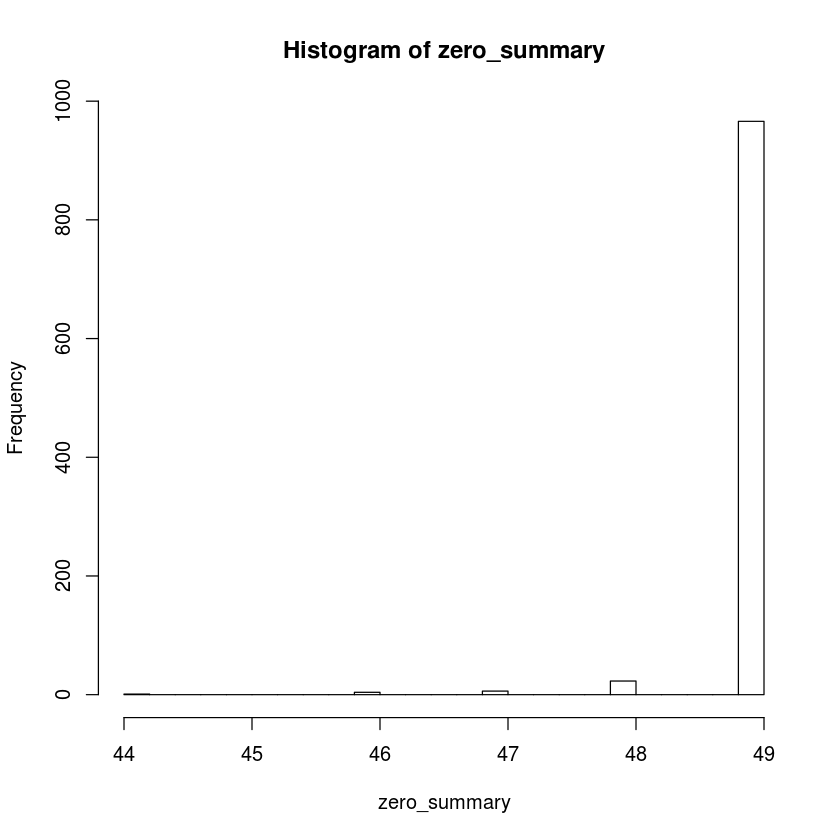

In [19]:
hist(zero_summary, breaks = 20)

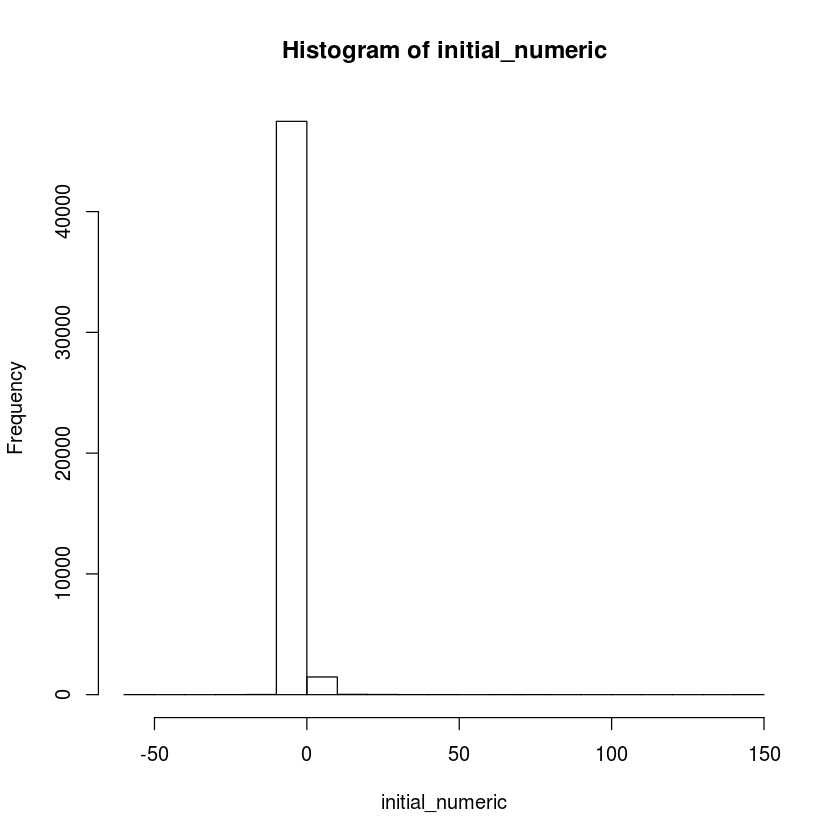

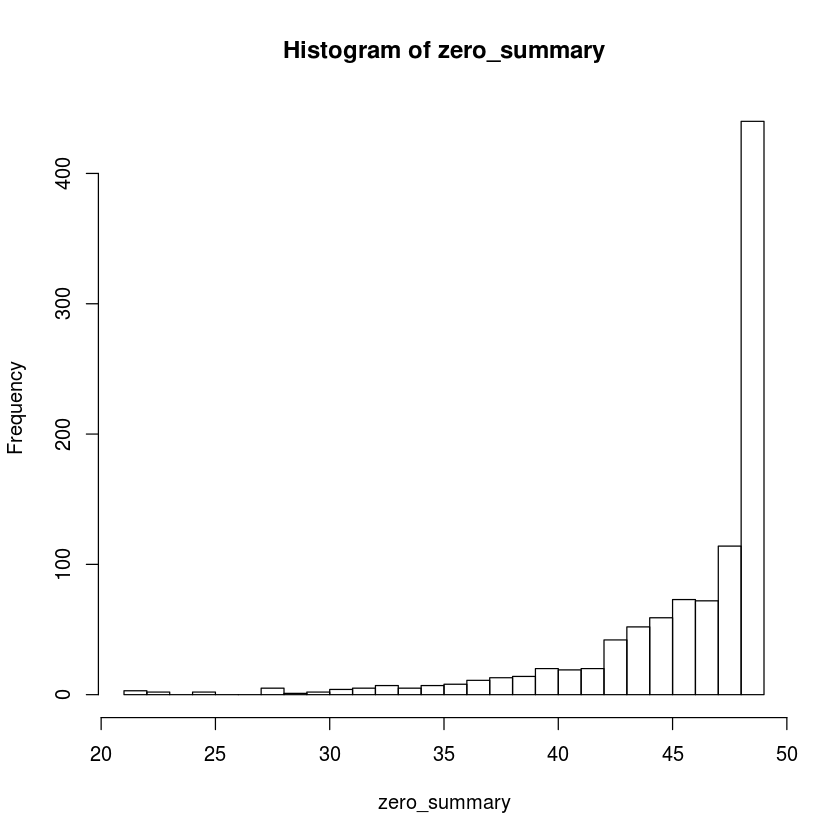

In [26]:
plot_est(multi_theta_est[[1]])

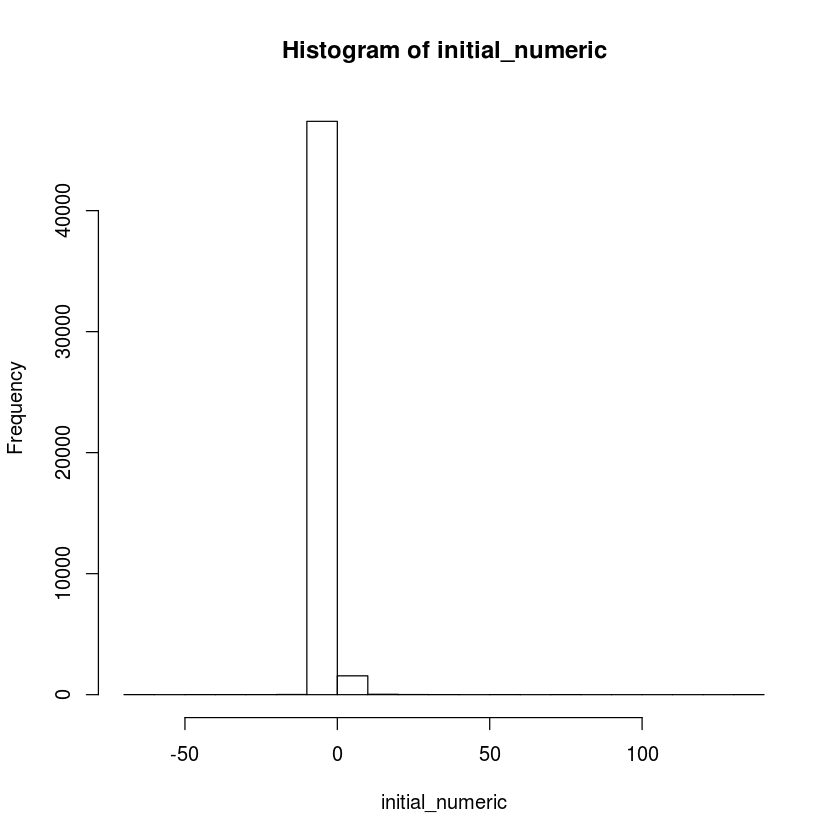

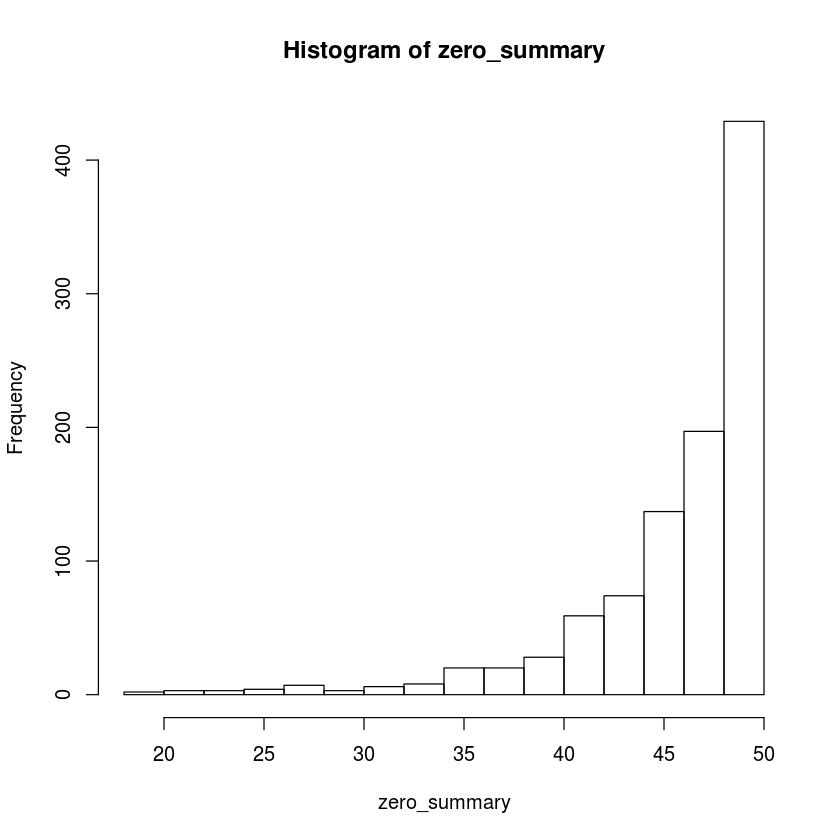

In [27]:
plot_est(multi_theta_est[[2]])

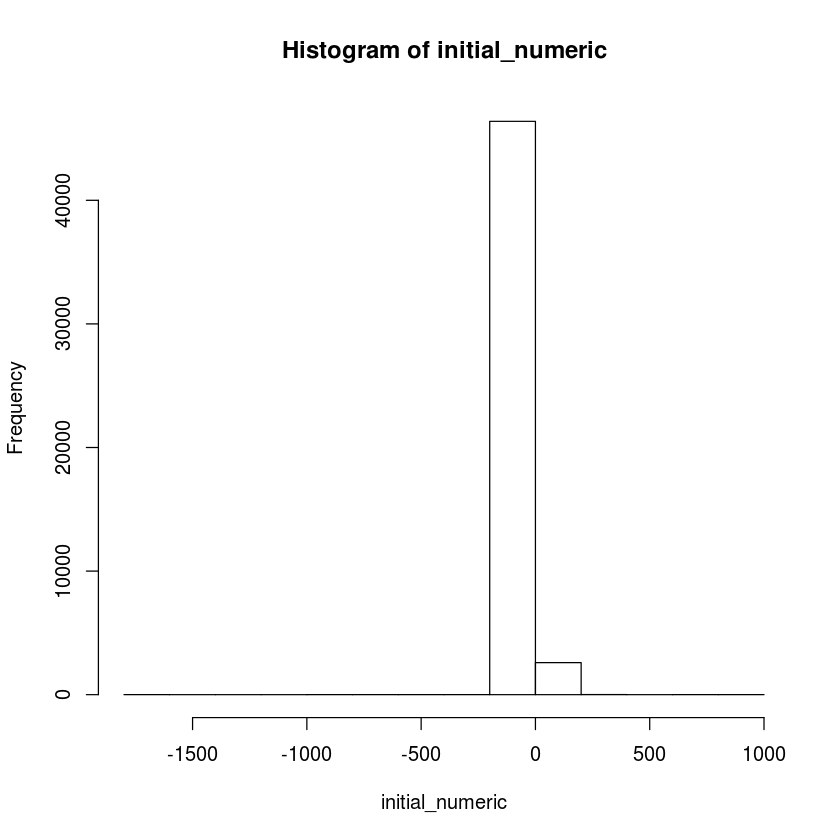

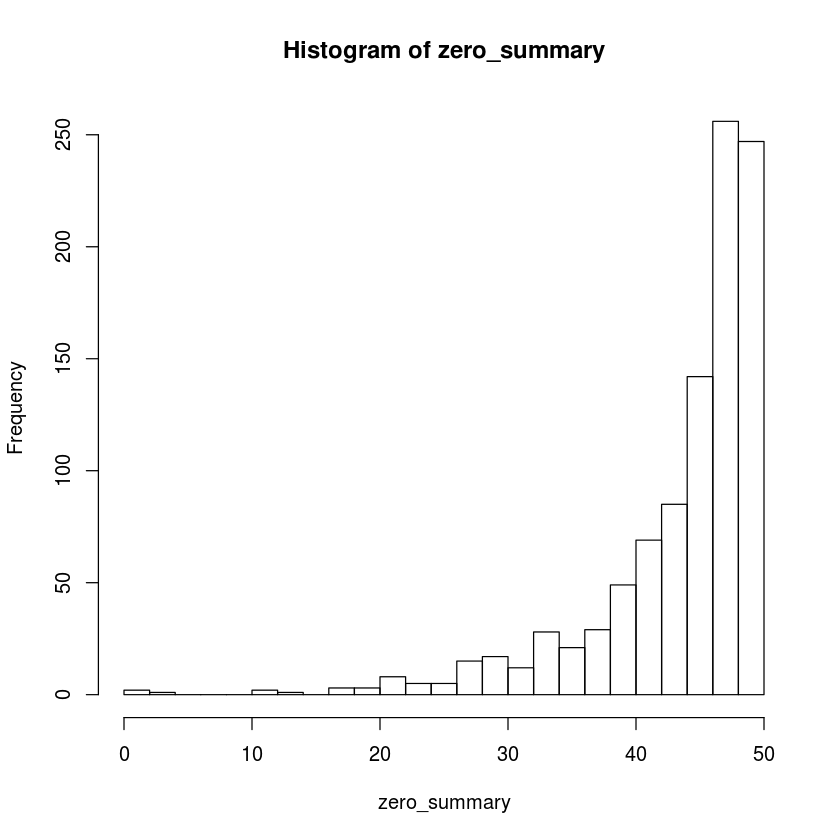

In [28]:
plot_est(multi_theta_est[[3]])

In [20]:
sum(zero_summary != 49)

[1] 34

In [ ]:
length(zero_summary)

In [ ]:
glasso <- function(X, Y, XX, XY, Xnorm, lambda1, lambda2, theta, stepsize = 1e-4, maxiter = 50, eps = 1e-3, verbose = FALSE){
	Bgt = Sys.time()
	M = nrow(XY)
	P = length(X)
	NN = unlist(lapply(X, nrow))
	old_objV1 = rep(0,P)
	for(t in 1:P){
		old_objV1[t] = 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
	}
  if (verbose) {
    cat("Training error: ", old_objV1, '\n')	
  }
	
	beta_j_lasso = rep(0, P)
	tmp_XYj = 0
	if(!is.loaded("wrapper")){
		dyn.load("/ysm-gpfs/pi/zhao/from_louise/yh367/GTEX/codes/glasso.so") # change this to the abs path to optim.so
	}
	for(i in 1:maxiter){
		bgt = Sys.time()
		res = .Call("wrapper", XX, XY, theta, M, P, beta_j_lasso, lambda1, lambda2, Xnorm)
		edt = Sys.time()
		
		new_objV1 = rep(0,P)
		for(t in 1:P){
			new_objV1[t] = 1/2*mean((Y[[t]]-X[[t]]%*%theta[,t])^2)
		}
		if (verbose) {IRdisplay::display_html(paste0("Training error: ", new_objV1, '\n'))}
		
        # mean objective
		if(mean(new_objV1) > mean(old_objV1)){
			break
		}
        
        # update criteria
		if (max(abs(new_objV1-old_objV1)) < eps) {
			break
		} else {
			old_objV1 = new_objV1
		}
	}
	Edt = Sys.time()
	cat("total training time: ", Edt-Bgt, "\n")
	list(est = theta, avg_train_err = mean(new_objV1), train_err=new_objV1)
}

In [6]:

bgt = Sys.time()


k = "1"
X_all = list()
Y_all = list()
for(t in 1:T_num){
    X_all_tmp = sub_id_map[[t]]
    X_all[[t]] = apply(as.matrix(dose_std[,X_all_tmp]),1,as.numeric)
    Y_all[[t]] = Y[[t]][which(sub_id_map_exp[[t]] == T), 2]
}
# initial values 
single_initial_est = matrix(0, ncol(X_train[[1]]), T_num)
for(t in 1:T_num){
    IRdisplay::display_html(paste0("Tissue ", t))
    tt = cv.glmnet(X_all[[t]], Y_all[[t]], alpha = 0.5, nfolds = 5)
    single_initial_est[,t] = tt$glmnet.fit$beta[,which.min(tt$cvm)]
}

sig_norm = apply(single_initial_est, 1, function(x){sqrt(sum(x^2))})
sig_norm[sig_norm==0] = rep(min(sig_norm[sig_norm>0]), sum(sig_norm==0))/2
sig_norm = sig_norm/sum(sig_norm)
weights2 = 1/sig_norm; weights2 = weights2/sum(weights2);

tis_norm = apply(single_initial_est, 2, function(x){sum(abs(x))})
tis_norm[tis_norm==0] = rep(min(tis_norm[tis_norm>0]), sum(tis_norm==0))/2
tis_norm = tis_norm/sum(tis_norm)
weights1 = 1/tis_norm; weights1 = weights1/sum(weights1);

spsz = unlist(lapply(X_all,nrow))
initial_numeric = as.numeric(single_initial_est)
#remove(single_initial_est)
XY = grad_prep(X_all, Y_all)

XX_all = lapply(X_all, function(x){eigenMatMult(t(x), x)/nrow(x)})
tmp_res = rep(0, fold)
for(f in 1:fold){


    ans = glasso(X=X_all, Y=Y_all, XX=XX_all, XY=XY, Xnorm=Xnorm, lambda1=multi_lam[f,1]/spsz, lambda2=multi_lam[f,2], theta=matrix(initial_numeric,M,P), verbose = if_verbose)
    tmp_res[f] = ans$avg_train_err
}
final.lam = multi_lam[which.min(tmp_res),]
ans = glasso(X=X_all, Y=Y_all, XX=XX_all, XY=XY, Xnorm=Xnorm, lambda1=final.lam[1]/spsz, lambda2=final.lam[2], theta=matrix(initial_numeric,M,P), verbose = if_verbose)
#info = read.table(info_path, header=T, sep='\t')
#downstream_est = data.frame(info[,1:3], ans$est)
multi_all_res = multi_mse(ans$est, X_all, Y_all)
single_all_res = multi_mse(single_initial_est, X_all, Y_all)

#info = read.table(info_path, header=T, sep='\t')
info = genotype_info$bim
downstream_est = data.frame(info[1:1000, ], ans$est)
#downstream_est = data.frame(info, ans$est)
edt = Sys.time()
print(edt-bgt)

Tissue 1

Tissue 2

Tissue 3

Tissue 4

Tissue 5

Tissue 6

Tissue 7

Tissue 8

Tissue 9

Tissue 10

Tissue 11

Tissue 12

Tissue 13

Tissue 14

Tissue 15

Tissue 16

Tissue 17

Tissue 18

Tissue 19

Tissue 20

Tissue 21

Tissue 22

Tissue 23

Tissue 24

Tissue 25

Tissue 26

Tissue 27

Tissue 28

Tissue 29

Tissue 30

Tissue 31

Tissue 32

Tissue 33

Tissue 34

Tissue 35

Tissue 36

Tissue 37

Tissue 38

Tissue 39

Tissue 40

Tissue 41

Tissue 42

Tissue 43

Tissue 44

Tissue 45

Tissue 46

Tissue 47

Tissue 48

Tissue 49

Training error:  87.53052 80.30783 1.579152 11.96649 7.101965 75.51774 27.44291 18.80179 2.310168 0.4344715 0.6302446 1.7194 4.407714 4.058322 6.340478 0.7986082 1.201295 1.756662 0.7670091 117.3791 5.573785 221.1587 11.67614 3.01597 6.035344 93.78616 79.91211 6.601775 2.044606 28.23102 0.4963709 14.54012 9.816847 1.443434 251.2447 6.078707 0.5228069 11.80341 2.602573 8.893407 14.56334 6.354834 607.6912 78.53181 0.9771653 63.51137 2.607468 16.1589 289.2907 


ERROR: Error in mean((Y1[[t]] - X1[[t]] %*% theta[, t])^2): object 'Y1' not found


In [3]:
save(downstream_est, file = "test_est.RData")

In [4]:
dim(downstream_est)

[1] 1000   55

In [5]:
downstream_est[1:100, 1:50]

,chr,id,posg,pos,ref,alt,X1,X2,X3,X4,⋯,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44
,<chr>,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,21,chr21_40464521_A_G_b38,0,40464521,G,A,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,21,chr21_40464616_T_C_b38,0,40464616,C,T,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,21,chr21_40464797_G_A_b38,0,40464797,A,G,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,21,chr21_40464826_T_C_b38,0,40464826,C,T,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,21,chr21_40464961_G_A_b38,0,40464961,A,G,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,21,chr21_40465271_T_C_b38,0,40465271,T,C,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
7,21,chr21_40465366_C_T_b38,0,40465366,T,C,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
8,21,chr21_40466036_C_T_b38,0,40466036,T,C,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
9,21,chr21_40466218_C_A_b38,0,40466218,A,C,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


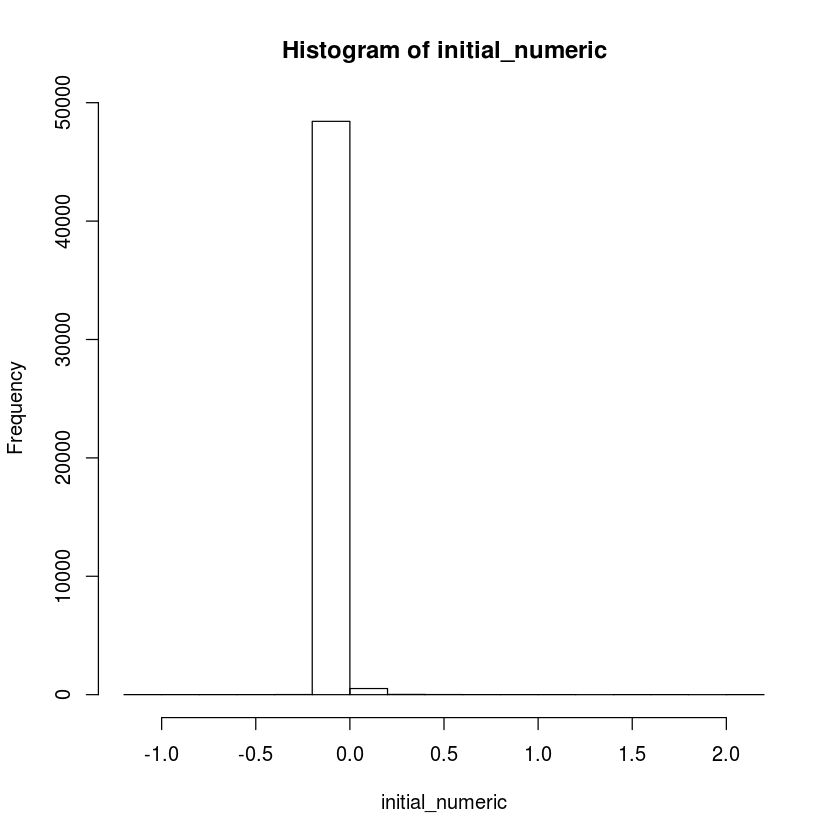

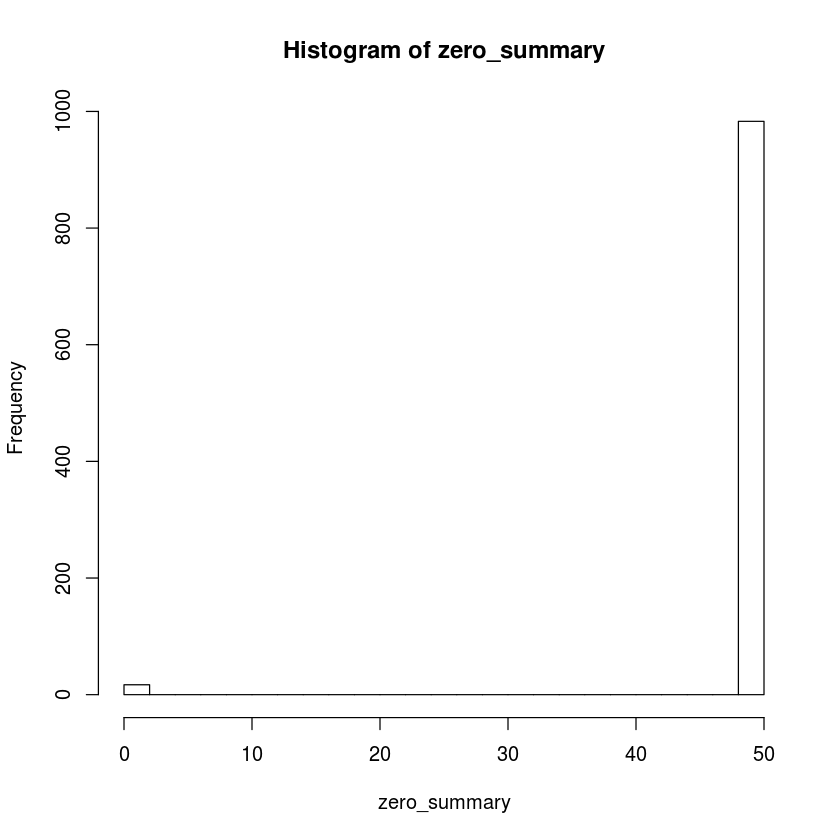

In [8]:
plot_est(t(downstream_est[,7:55]))

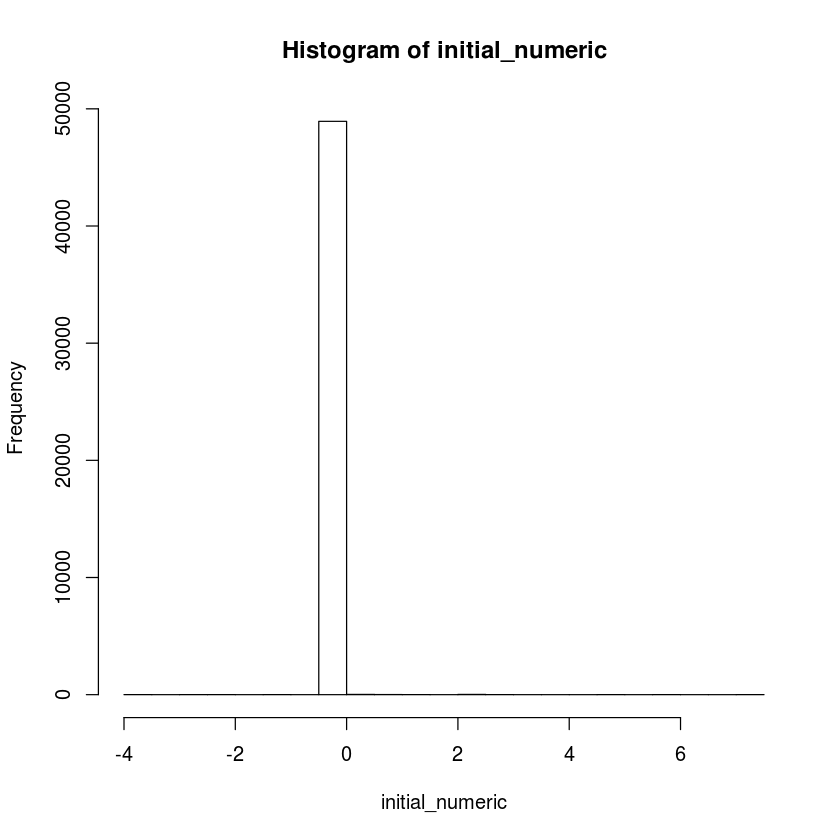

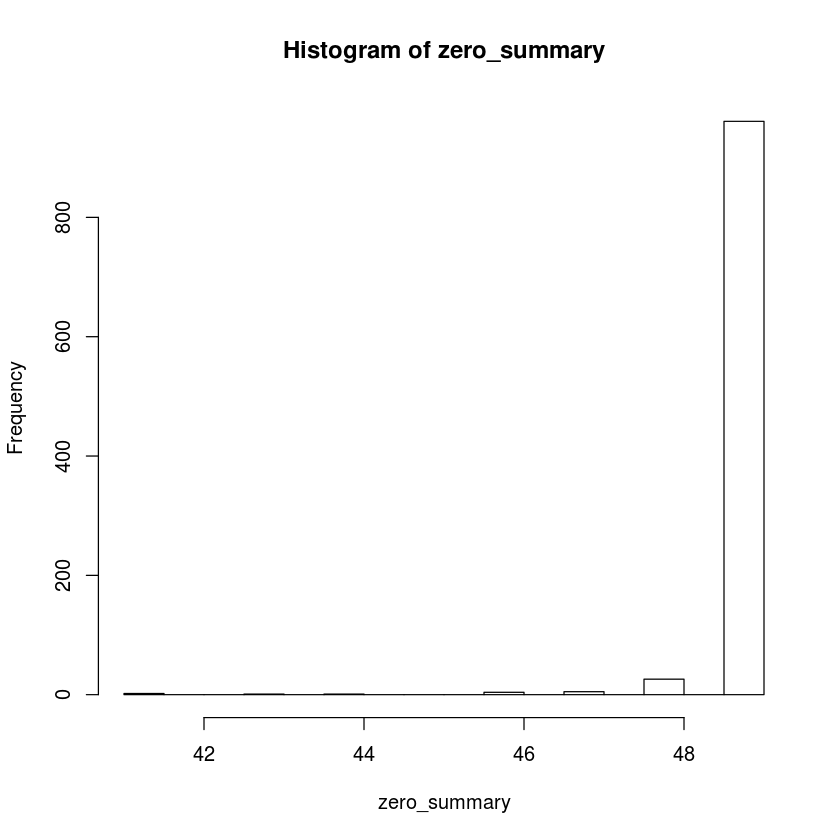

In [9]:
plot_est(initial_numeric)

In [2]:
save(single_res_test, single_lam, single_theta_est, multi_res_test, multi_lam, multi_theta_est, file = paste0('chr', chr, '.', k, '.', gene_id, ".RData"))
	#res_single = avg_perm(single_res_test)
	#res_multi = avg_perm(multi_res_test)
	#cat("Elastic net average testing error (all): ", apply(res_single, 2, mean), '\n')
	#cat("glasso averge testing error (all): ", apply(res_multi, 2, mean), '\n')
	#cat("Number of all zero tissues in elastic net is ", sum(is.na(res_single[,1])), '\n')
	#cat("Number of all zero tissues in glasso is ", sum(is.na(res_multi[,1])), '\n')
	#cat("Elastic net average testing error (non-zero): ", apply(res_single[!is.na(res_multi[,1]),], 2, mean), '\n')
	#cat("glasso averge testing error (non-zero): ", apply(res_multi[!is.na(res_multi[,1]),], 2, mean), '\n')

	## generate an estimate with whole data ##
	
	#write.table(downstream_est, paste0(gene_id, ".est"), quote=F, row.names=F, col.names=c("SNP", "REF.0.", "ALT.1.", Yt))
    write.table(downstream_est, paste0(gene_id, ".est"), quote=F, row.names=F, col.names=c(colnames(genotype_info$bim), Yt))



Training error: 2306.63991985794
Training error: 2370.47650114781
Training error: 2306.63991985794
Training error: 2370.47650114781
Training error: 2306.63991985794
Training error: 2370.47650114781
Training error: 2306.63991985794
Training error: 2370.47650114781
Training error: 2306.63991985794
Training error: 2370.47650114781
Training error: 2306.63991985794
Training error: 2370.47650114781


In [9]:
length(ans$est)

[1] 523663

In [7]:
sum(initial_numeric == 0)

[1] 523429

In [8]:
length(initial_numeric)

[1] 523663

In [ ]:
for (obj in ls()) { 
    message(obj)
    print(object.size(get(obj)), units='auto') 
}

In [3]:
length(XX_train)

[1] 49

In [4]:
dim(XX_train[[1]])

[1] 10687 10687

In [5]:
test_mtx <- as.big.matrix(XX_train[[1]])

In [6]:
print(object.size(XX_train[[1]]), units='auto')

871.4 Mb


In [7]:
test_mtx <- matrix(1.57, 10000, 10000 )

In [8]:
print(object.size(test_mtx), units = "auto")

762.9 Mb


In [ ]:
dim(test_mtx)

In [10]:
test_mtx[1:6, 1:6]

1.57,1.57,1.57,1.57,1.57,1.57
1.57,1.57,1.57,1.57,1.57,1.57
1.57,1.57,1.57,1.57,1.57,1.57
1.57,1.57,1.57,1.57,1.57,1.57
1.57,1.57,1.57,1.57,1.57,1.57
1.57,1.57,1.57,1.57,1.57,1.57


In [11]:
XX_train[[1]][1:6, 1:6]

0.11700682,0.11700682,-0.01664066,0.09849660,0.10877685,-0.04667148
0.11700682,0.11700682,-0.01664066,0.09849660,0.10877685,-0.04667148
-0.01664066,-0.01664066,0.21854696,0.19724280,-0.01430092,-0.09354227
0.09849660,0.09849660,0.19724280,0.30699923,0.09279519,-0.15061144
0.10877685,0.10877685,-0.01430092,0.09279519,0.10954468,-0.04445851
-0.04667148,-0.04667148,-0.09354227,-0.15061144,-0.04445851,0.48489715


In [5]:
#save(single_res_test, single_lam, single_theta_est, multi_res_test, multi_lam, multi_theta_est, res_tune, rec_lamv, file = paste0(output_dir, '/', gene_id, ".cv.evaluation.RData"))
save(single_res_test, single_lam, single_theta_est, multi_res_test, multi_lam, multi_theta_est, res_tune, file = paste0(output_dir, '/', gene_id, ".cv.evaluation.RData"))
                                  
	res_single = avg_perm(single_res_test)
	res_multi = avg_perm(multi_res_test)
	cat("Elastic net average testing error (all): ", apply(res_single, 2, mean), '\n')
	cat("glasso averge testing error (all): ", apply(res_multi, 2, mean), '\n')
	cat("Number of all zero tissues in elastic net is ", sum(is.na(res_single[,1])), '\n')
	cat("Number of all zero tissues in glasso is ", sum(is.na(res_multi[,1])), '\n')
	cat("Elastic net average testing error (non-zero): ", apply(res_single[!is.na(res_multi[,1]),], 2, mean), '\n')
	cat("glasso averge testing error (non-zero): ", apply(res_multi[!is.na(res_multi[,1]),], 2, mean), '\n')

  #------------ use tuning parameter chosen above to train model on entire dataset -------------#
	## generate an estimate with whole data ##
  cat('training a model on entire data with parameters chosen from cv\n')
	X_all = list()
	Y_all = list()
	for(t in 1:T_num){
		X_all_tmp = sub_id_map[[t]]
        X_all[[t]] = apply(as.matrix(dose_std[,X_all_tmp]),1,as.numeric)
		#X_all[[t]] = apply(as.matrix(dose[X_all_tmp,-c(1)]),2,as.numeric)
		Y_all[[t]] = Y[[t]][which(sub_id_map_exp[[t]] == T), 2]
	}
	# initial values 
	single_initial_est = matrix(0, ncol(X_train[[1]]), T_num)
	for(t in 1:T_num){
		tt = cv.glmnet(X_all[[t]], Y_all[[t]], alpha = 0.5, nfolds = 5)
		single_initial_est[,t] = tt$glmnet.fit$beta[,which.min(tt$cvm)]
	}

	sig_norm = apply(single_initial_est, 1, function(x){sqrt(sum(x^2))})
	sig_norm[sig_norm==0] = rep(min(sig_norm[sig_norm>0]), sum(sig_norm==0))/2
	sig_norm = sig_norm/sum(sig_norm)
	weights2 = 1/sig_norm; weights2 = weights2/sum(weights2);

	tis_norm = apply(single_initial_est, 2, function(x){sum(abs(x))})
	tis_norm[tis_norm==0] = rep(min(tis_norm[tis_norm>0]), sum(tis_norm==0))/2
	tis_norm = tis_norm/sum(tis_norm)
	weights1 = 1/tis_norm; weights1 = weights1/sum(weights1);

	spsz = unlist(lapply(X_all,nrow))
	initial_numeric = as.numeric(single_initial_est)
	#remove(single_initial_est)
	XY = grad_prep(X_all, Y_all)
	XX_all = lapply(X_all, function(x){t(x)%*%x/nrow(x)})
	tmp_res = rep(0, fold)
	for (f in 1:fold){
		#ans = glasso_no_early_stopping(X=X_all, Y=Y_all, XX=XX_all, XY=XY, Xnorm=Xnorm, lambda1=multi_lam[f,1]/spsz, lambda2=multi_lam[f,2], theta=matrix(initial_numeric,M,P))#, verbose = if_verbose)
		ans = glasso_no_early_stopping(X=X_all, Y=Y_all, XX=XX_all, XY=XY, Xnorm=Xnorm, lambda1=multi_lam[f]/spsz, lambda2=multi_lam[f], theta=matrix(initial_numeric,M,P))#, verbose = if_verbose)
        tmp_res[f] = ans$avg_train_err
	}
	final.lam = multi_lam[which.min(tmp_res),]
	ans = glasso_no_early_stopping(X=X_all, Y=Y_all, XX=XX_all, XY=XY, Xnorm=Xnorm, lambda1=final.lam[1]/spsz, lambda2=final.lam[2], theta=matrix(initial_numeric,M,P))#, verbose = if_verbose)
	info = read.table(info_path, header=T, sep='\t')
    downstream_est = data.frame(info[,1:3], ans$est)
	multi_all_res = multi_mse(ans$est, X_all, Y_all)
	single_all_res = multi_mse(single_initial_est, X_all, Y_all)
  cat('writing final estimates\n')
	write.table(downstream_est, paste0(output_dir, '/', gene_id, ".est"), quote = F, row.names = F, col.names = c("SNP", "REF.0.", "ALT.1.", Yt))

  cat('saving the prediction on all data for future analysis\n')
	save(multi_all_res, single_all_res, final.lam, ans, file = paste0(output_dir, '/', gene_id, ".prediction_on_all_data.RData"))
  cat('done!\n')
    

Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning message in cor(mse_lst[[f]][[t]]):
“the standard deviation is zero”
Warning mess

Elastic net average testing error (all):  NA 99.70318 1.093741 
glasso averge testing error (all):  NA 96.68083 1.008235 
Number of all zero tissues in elastic net is  47 
Number of all zero tissues in glasso is  49 
Elastic net average testing error (non-zero):  NaN NaN NaN 
glasso averge testing error (non-zero):  NaN NaN NaN 
training a model on entire data with parameters chosen from cv
Training error: 2306.63991985794


ERROR: Error in multi_lam[f, 1]: incorrect number of dimensions
